# Task 1: Unsupervised Domain Adaptation - Art to Real-World




## 1. Introduction

This notebook implements and compares multiple Unsupervised Domain Adaptation (UDA) methods on the Office-Home dataset, specifically adapting from **Art (source)** to **Real-World (target)** domains.

**Domain Description:**
- **Source (Art)**: Artistic renderings, paintings, sketches - abstract textures and stylized representations
- **Target (Real-World)**: Real photographs - realistic textures, lighting, and natural appearance

**Methods Compared:**
1. Source-Only Baseline (ERM)
2. DAN (Deep Adaptation Network) - Statistical alignment via MMD
3. DANN (Domain Adversarial Neural Network) - Adversarial alignment
4. CDAN (Conditional Domain Adversarial Network) - Class-aware adversarial alignment
5. Self-Training with Pseudo-labeling

**Theoretical Foundation:**
According to Ben-David et al.'s theory, target error is bounded by:
$\varepsilon_t \le \varepsilon_s + d_H(D_s, D_t) + \lambda$
where reducing domain divergence $d_H$ helps minimize target error.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC
from collections import defaultdict
import os
import random
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Dataset Preparation

PACS dataset structure:
```
PACS/
  art_painting/
  photo/
  cartoon/
  sketch/
```


In [2]:
from datasets import load_dataset
print("Loading PACS dataset from HuggingFace...")
full_dataset = load_dataset("flwrlabs/pacs")  # user provided dataset name
# dataset splits: inspect
print("Dataset keys:", list(full_dataset.keys()))
# we expect 'train' split containing domain field for each sample

# Get domain list and label names (if available)
domains = sorted(list(set(full_dataset['train'].unique('domain'))))
print("Domains detected:", domains)

Loading PACS dataset from HuggingFace...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Dataset keys: ['train']
Domains detected: ['art_painting', 'cartoon', 'photo', 'sketch']


In [5]:
from datasets import load_dataset
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [6]:
class PACSHFDataset(Dataset):
    def __init__(self, hf_subset, transform=None, return_label=True):
        self.data = hf_subset
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[int(idx)]
        image = item["image"].convert("RGB")
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        if self.return_label:
            return image, int(label)
        else:
            # Unsupervised (no labels returned)
            return image

# -----------------------------
# 5. Domain setup for DA
# -----------------------------
SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
TARGET_DOMAIN = "sketch"
TEST_RATIO = 0.2

# helper to filter hf dataset by domain
def filter_domain(ds, domain_name):
    return ds.filter(lambda x: x["domain"] == domain_name)

# -----------------------------
# 6. Split into train/test per domain
# -----------------------------
def split_dataset(hf_domain_ds, test_ratio=TEST_RATIO, seed=SEED):
    n = len(hf_domain_ds)
    indices = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(indices)
    split_idx = int(n * (1 - test_ratio))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    return hf_domain_ds.select(train_idx), hf_domain_ds.select(test_idx)

# -----------------------------
# 7. Build datasets for each domain
# -----------------------------
source_train_sets = []
source_test_sets = []

for domain in SOURCE_DOMAINS:
    hf_domain = filter_domain(full_dataset["train"], domain)
    hf_train, hf_test = split_dataset(hf_domain)

    train_ds = PACSHFDataset(hf_train, transform=train_transform, return_label=True)
    test_ds = PACSHFDataset(hf_test, transform=test_transform, return_label=True)
    source_train_sets.append(train_ds)
    source_test_sets.append(test_ds)
    print(f"Source {domain}: train={len(train_ds)}, test={len(test_ds)}")

# Combine all source domains (labeled)
source_train = ConcatDataset(source_train_sets)
source_test = ConcatDataset(source_test_sets)

# Target domain (unlabeled for DA)
hf_target = filter_domain(full_dataset["train"], TARGET_DOMAIN)
hf_target_train, hf_target_test = split_dataset(hf_target)

target_train_dataset = PACSHFDataset(hf_target_train, transform=train_transform, return_label=False)
target_test_dataset = PACSHFDataset(hf_target_test, transform=test_transform, return_label=True)

print(f"Target ({TARGET_DOMAIN}): train={len(target_train_dataset)}, test={len(target_test_dataset)}")

# -----------------------------
# 8. Create DataLoaders
# -----------------------------
BATCH_SIZE = 32

source_loader = DataLoader(source_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
source_test_loader = DataLoader(source_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
target_loader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_test_loader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
NUM_CLASSES = 7

print("\n✅ PACS UDA setup complete!")
print(f"Total source train: {len(source_train)} | target train (unlabeled): {len(target_train_dataset)}")

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Source art_painting: train=1638, test=410


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Source cartoon: train=1875, test=469


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Source photo: train=1336, test=334


Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Target (sketch): train=3143, test=786

✅ PACS UDA setup complete!
Total source train: 4849 | target train (unlabeled): 3143


In [7]:
for _, labels in DataLoader(source_train, batch_size=128):
    print(labels.min().item(), labels.max().item())
    break


0 6


## 3. Model Architecture + Visualization code

We use ResNet-50 pretrained on ImageNet as our backbone for all experiments.


In [8]:
class FeatureExtractor(nn.Module):
    """ResNet-50 feature extractor"""
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_dim = 2048

        # UnFreeze all layers
        for param in resnet.parameters():
            param.requires_grad = True

        # # Unfreeze layer4
        # for param in resnet.layer4.parameters():
        #     param.requires_grad = True

        # for param in resnet.layer3.parameters():
        #     param.requires_grad = True

        self.features = nn.Sequential(*list(resnet.children())[:-1])
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class Classifier(nn.Module):
    """Simple classifier head"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from PIL import Image
import os

# ImageNet normalization (adjust if you used different values)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def unnormalize_tensor_image(tensor):
    """Convert normalized tensor to displayable image"""
    if isinstance(tensor, torch.Tensor):
        img = tensor.detach().cpu().numpy()
    else:
        img = np.array(tensor)
    if img.ndim == 3 and img.shape[0] in (1, 3):
        img = np.transpose(img, (1, 2, 0))
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img


# ============================================================================
# HELPER: Extract features
# ============================================================================
def extract_features_with_domain(feature_extractor, source_loader, target_loader, max_samples=1000):
    """Extract features from both source and target"""
    feature_extractor.eval()
    device = next(feature_extractor.parameters()).device
    
    def extract_from_loader(loader, max_count):
        feats, labels = [], []
        with torch.no_grad():
            total = 0
            for images, lbls in loader:
                if total >= max_count:
                    break
                images = images.to(device)
                f = feature_extractor(images).cpu().numpy()
                feats.append(f)
                labels.append(lbls.numpy())
                total += f.shape[0]
        return (np.vstack(feats) if feats else np.zeros((0, 2048)),
                np.concatenate(labels) if labels else np.array([]))
    
    s_feats, s_labels = extract_from_loader(source_loader, max_samples // 2)
    t_feats, t_labels = extract_from_loader(target_loader, max_samples // 2)
    
    return s_feats, s_labels, t_feats, t_labels


def get_predictions(feature_extractor, classifier, loader):
    """Get predictions and labels from a loader"""
    feature_extractor.eval()
    classifier.eval()
    device = next(feature_extractor.parameters()).device
    
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = feature_extractor(images)
            logits = classifier(feats)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    return (np.concatenate(all_preds), 
            np.concatenate(all_labels),
            np.vstack(all_probs))


# ============================================================================
# PER-MODEL VISUALIZATION (all details for ONE method)
# ============================================================================
def visualize_single_model(name, feature_extractor, classifier,
                           source_dataset, target_dataset,
                           source_test_loader, target_test_loader,
                           num_classes, class_names=None,
                           max_tsne_samples=1000, show_classes=None,
                           output_dir='viz_outputs'):
    """
    Complete visualization suite for a SINGLE model:
    1. Random source vs target images
    2. Class-colored t-SNE (side-by-side: domain view + class view)
    3. Better confusion matrix (normalized + annotated)
    4. Per-class metrics (F1, precision, recall bar chart)
    
    Saves all to output_dir/model_name/
    """
    print(f"\n{'='*60}")
    print(f"Visualizing: {name}")
    print(f"{'='*60}")
    
    # Create output directory
    model_dir = os.path.join(output_dir, name.replace(' ', '_'))
    os.makedirs(model_dir, exist_ok=True)
    
    if class_names is None:
        class_names = [f'C{i}' for i in range(num_classes)]
    
    # -------------------------
    # 1. Random Images
    # -------------------------
    # print("1/4 Plotting random images...")
    # fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    # src_idx = np.random.choice(len(source_dataset), size=5, replace=False)
    # tgt_idx = np.random.choice(len(target_dataset), size=5, replace=False)
    
    # for i in range(5):
    #     s_img, s_lbl = source_dataset[src_idx[i]][:2]
    #     t_img, t_lbl = target_dataset[tgt_idx[i]][:2]
        
    #     if isinstance(s_img, Image.Image):
    #         s_img = np.asarray(s_img) / 255.0
    #     else:
    #         s_img = unnormalize_tensor_image(s_img)
        
    #     if isinstance(t_img, Image.Image):
    #         t_img = np.asarray(t_img) / 255.0
    #     else:
    #         t_img = unnormalize_tensor_image(t_img)
        
    #     axes[0, i].imshow(s_img)
    #     axes[0, i].set_title(f'Src: {class_names[s_lbl]}', fontsize=9)
    #     axes[0, i].axis('off')
        
    #     axes[1, i].imshow(t_img)
    #     axes[1, i].set_title(f'Tgt: {class_names[t_lbl]}', fontsize=9)
    #     axes[1, i].axis('off')
    
    # plt.suptitle(f'{name} - Source vs Target Samples', fontsize=14, fontweight='bold')
    # plt.tight_layout()
    # plt.savefig(os.path.join(model_dir, 'random_images.png'), dpi=200, bbox_inches='tight')
    # plt.close()
    
    # -------------------------
    # 2. t-SNE (dual view)
    # -------------------------
    print("2/4 Computing t-SNE...")
    s_feats, s_labels, t_feats, t_labels = extract_features_with_domain(
        feature_extractor, source_test_loader, target_test_loader, max_tsne_samples
    )
    
    # Select classes to show
    if show_classes is None:
        if num_classes > 15:
            all_labels = np.concatenate([s_labels, t_labels])
            class_counts = np.bincount(all_labels, minlength=num_classes)
            show_classes = np.argsort(class_counts)[-10:][::-1]
        else:
            show_classes = list(range(num_classes))
    
    # Filter
    s_mask = np.isin(s_labels, show_classes)
    t_mask = np.isin(t_labels, show_classes)
    s_feats_sub = s_feats[s_mask]
    s_labels_sub = s_labels[s_mask]
    t_feats_sub = t_feats[t_mask]
    t_labels_sub = t_labels[t_mask]
    
    if len(s_feats_sub) > 0 and len(t_feats_sub) > 0:
        # Combine
        all_feats = np.vstack([s_feats_sub, t_feats_sub])
        all_labels = np.concatenate([s_labels_sub, t_labels_sub])
        
        # PCA + t-SNE
        if all_feats.shape[1] > 50:
            pca = PCA(n_components=50, random_state=42)
            all_feats = pca.fit_transform(all_feats)
        
        perpl = min(30, max(5, (len(all_feats) - 1) // 3))
        tsne = TSNE(n_components=2, random_state=42, perplexity=perpl,
                   n_iter=1000, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(all_feats)
        
        # Plot side-by-side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        n_source = len(s_feats_sub)
        
        # LEFT: Domain view
        ax1.scatter(embedded[:n_source, 0], embedded[:n_source, 1],
                   c='dodgerblue', s=25, alpha=0.6, label='Source', edgecolors='navy', linewidths=0.3)
        ax1.scatter(embedded[n_source:, 0], embedded[n_source:, 1],
                   c='orangered', s=25, alpha=0.6, label='Target', edgecolors='darkred', linewidths=0.3)
        ax1.set_title('Domain Alignment View\n(Are source & target mixed?)', 
                     fontsize=12, fontweight='bold')
        ax1.legend(fontsize=10, loc='best')
        ax1.set_xlabel('t-SNE 1', fontsize=10)
        ax1.set_ylabel('t-SNE 2', fontsize=10)
        ax1.grid(alpha=0.3)
        
        # RIGHT: Class view
        colors = plt.cm.tab10(np.linspace(0, 1, len(show_classes)))
        for i, cls in enumerate(show_classes):
            # Source
            s_idx = np.where(all_labels[:n_source] == cls)[0]
            if len(s_idx) > 0:
                ax2.scatter(embedded[s_idx, 0], embedded[s_idx, 1],
                           c=[colors[i]], marker='o', s=35, alpha=0.7,
                           edgecolors='black', linewidths=0.5,
                           label=f'{class_names[cls]}')
            
            # Target
            t_idx = np.where(all_labels[n_source:] == cls)[0] + n_source
            if len(t_idx) > 0:
                ax2.scatter(embedded[t_idx, 0], embedded[t_idx, 1],
                           c=[colors[i]], marker='x', s=50, alpha=0.85,
                           linewidths=2.0)
        
        ax2.set_title('Class Preservation View\n(Are classes separated? o=src, x=tgt)', 
                     fontsize=12, fontweight='bold')
        ax2.set_xlabel('t-SNE 1', fontsize=10)
        ax2.set_ylabel('t-SNE 2', fontsize=10)
        ax2.grid(alpha=0.3)
        
        # Legend (show only a few classes to avoid clutter)
        handles, labels = ax2.get_legend_handles_labels()
        if len(handles) > 10:
            ax2.legend(handles[:10], labels[:10], loc='center left', 
                      bbox_to_anchor=(1, 0.5), fontsize=8)
        else:
            ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
        
        plt.suptitle(f't-SNE Feature Space: {name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, 'tsne_dual_view.png'), dpi=250, bbox_inches='tight')
        plt.close()
    
    # -------------------------
    # 3. Better Confusion Matrix
    # -------------------------
    print("3/4 Generating confusion matrix...")
    preds, labels, probs = get_predictions(feature_extractor, classifier, target_test_loader)
    
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # Raw counts
    show_annot = num_classes <= 20
    sns.heatmap(cm, annot=show_annot, fmt='d', cmap='Blues', ax=ax1,
                cbar_kws={'label': 'Count'}, square=True)
    ax1.set_title(f'{name} - Raw Counts', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=11)
    ax1.set_ylabel('True Class', fontsize=11)
    
    # Normalized (shows per-class accuracy on diagonal)
    sns.heatmap(cm_normalized, annot=show_annot, fmt='.2f', cmap='RdYlGn', ax=ax2,
                vmin=0, vmax=1, cbar_kws={'label': 'Proportion'}, square=True)
    ax2.set_title(f'{name} - Normalized (Row %)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Predicted Class', fontsize=11)
    ax2.set_ylabel('True Class', fontsize=11)
    
    plt.suptitle(f'Confusion Matrix: {name} on Target Domain', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'), dpi=200, bbox_inches='tight')
    plt.close()
    
    # -------------------------
    # 4. Per-Class Metrics
    # -------------------------
    print("4/4 Computing per-class metrics...")
    
    # Compute per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, labels=np.arange(num_classes), average=None, zero_division=0
    )
    
    # Find rare classes
    class_counts = np.bincount(labels, minlength=num_classes)
    rarest_3 = np.argsort(class_counts)[:3]
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # F1 scores
    ax = axes[0, 0]
    x = np.arange(num_classes)
    bars = ax.bar(x, f1, color='steelblue', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(f1.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('F1 Score', fontsize=11)
    ax.set_title('Per-Class F1 Scores (Red = 3 rarest classes)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Precision
    ax = axes[0, 1]
    bars = ax.bar(x, precision, color='mediumseagreen', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(precision.mean(), color='darkgreen', linestyle='--', linewidth=2, 
              label=f'Mean: {precision.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title('Per-Class Precision', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Recall
    ax = axes[1, 0]
    bars = ax.bar(x, recall, color='coral', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(recall.mean(), color='darkred', linestyle='--', linewidth=2, 
              label=f'Mean: {recall.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Recall', fontsize=11)
    ax.set_title('Per-Class Recall', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Sample distribution
    ax = axes[1, 1]
    bars = ax.bar(x, class_counts, color='plum', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Sample Count', fontsize=11)
    ax.set_title('Target Class Distribution (Red = 3 rarest)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.suptitle(f'Per-Class Performance Metrics: {name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'per_class_metrics.png'), dpi=200, bbox_inches='tight')
    plt.close()
    
    # Save text summary
    with open(os.path.join(model_dir, 'metrics_summary.txt'), 'w') as f:
        f.write(f"{'='*60}\n")
        f.write(f"Model: {name}\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"Overall Accuracy: {(preds == labels).mean():.4f}\n")
        f.write(f"Macro F1: {f1.mean():.4f}\n")
        f.write(f"Macro Precision: {precision.mean():.4f}\n")
        f.write(f"Macro Recall: {recall.mean():.4f}\n\n")
        f.write(f"Rarest 3 classes: {rarest_3} with counts {class_counts[rarest_3]}\n")
        f.write(f"Rarest classes F1: {f1[rarest_3].mean():.4f}\n\n")
        f.write(f"{'='*60}\n")
        f.write("Per-Class Breakdown:\n")
        f.write(f"{'='*60}\n")
        for i in range(num_classes):
            f.write(f"Class {i:2d} ({class_names[i]:20s}): "
                   f"F1={f1[i]:.3f}, Prec={precision[i]:.3f}, Rec={recall[i]:.3f}, "
                   f"N={class_counts[i]:4d}\n")
    
    print(f"✓ All visualizations saved to: {model_dir}/")
    print(f"  - random_images.png")
    print(f"  - tsne_dual_view.png")
    print(f"  - confusion_matrix.png")
    print(f"  - per_class_metrics.png")
    print(f"  - metrics_summary.txt")


# ============================================================================
# GRID COMPARISONS (compare all methods)
# ============================================================================
def compare_all_methods_tsne_grid(models_dict, source_test_loader, target_test_loader,
                                  num_classes, max_samples=1000, show_classes=None,
                                  savepath='tsne_all_methods_grid.png', ncols=3):
    """
    Grid of class-colored t-SNE for all methods (like CDAN paper Figure 3)
    """
    print("\n" + "="*60)
    print("Creating t-SNE Grid for All Methods")
    print("="*60)
    
    methods = list(models_dict.keys())
    n_methods = len(methods)
    nrows = (n_methods + ncols - 1) // ncols
    
    fig = plt.figure(figsize=(7*ncols, 6*nrows))
    
    for idx, (name, feature_extractor) in enumerate(models_dict.items()):
        print(f"Processing {name} ({idx+1}/{n_methods})...")
        
        # Extract
        s_feats, s_labels, t_feats, t_labels = extract_features_with_domain(
            feature_extractor, source_test_loader, target_test_loader, max_samples
        )
        
        # Select classes
        if show_classes is None:
            if num_classes > 15:
                all_labels = np.concatenate([s_labels, t_labels])
                class_counts = np.bincount(all_labels, minlength=num_classes)
                current_show = np.argsort(class_counts)[-10:][::-1]
            else:
                current_show = list(range(num_classes))
        else:
            current_show = show_classes
        
        # Filter
        s_mask = np.isin(s_labels, current_show)
        t_mask = np.isin(t_labels, current_show)
        s_feats_sub = s_feats[s_mask]
        s_labels_sub = s_labels[s_mask]
        t_feats_sub = t_feats[t_mask]
        t_labels_sub = t_labels[t_mask]
        
        if len(s_feats_sub) == 0 or len(t_feats_sub) == 0:
            continue
        
        # Combine
        all_feats = np.vstack([s_feats_sub, t_feats_sub])
        all_labels = np.concatenate([s_labels_sub, t_labels_sub])
        
        # PCA + t-SNE
        if all_feats.shape[1] > 50:
            pca = PCA(n_components=50, random_state=42)
            all_feats = pca.fit_transform(all_feats)
        
        perpl = min(30, max(5, (len(all_feats) - 1) // 3))
        tsne = TSNE(n_components=2, random_state=42, perplexity=perpl,
                   n_iter=1000, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(all_feats)
        
        # Plot
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        colors = plt.cm.tab10(np.linspace(0, 1, len(current_show)))
        n_source = len(s_feats_sub)
        
        for i, cls in enumerate(current_show):
            # Source
            s_idx = np.where(all_labels[:n_source] == cls)[0]
            if len(s_idx) > 0:
                ax.scatter(embedded[s_idx, 0], embedded[s_idx, 1],
                          c=[colors[i]], marker='o', s=25, alpha=0.65,
                          edgecolors='black', linewidths=0.3)
            
            # Target
            t_idx = np.where(all_labels[n_source:] == cls)[0] + n_source
            if len(t_idx) > 0:
                ax.scatter(embedded[t_idx, 0], embedded[t_idx, 1],
                          c=[colors[i]], marker='x', s=35, alpha=0.85,
                          linewidths=1.5)
        
        ax.set_title(f'{name}', fontsize=13, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=9, label='Source', markeredgecolor='black'),
        Line2D([0], [0], marker='x', color='w', markerfacecolor='gray',
               markersize=9, label='Target', markeredgewidth=2)
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.9)
    
    fig.suptitle('t-SNE Comparison: All Methods (Same color = same class)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {savepath}")
    plt.show()


def compare_all_methods_heatmap(models_dict, classifiers_dict, target_test_loader,
                                num_classes, class_names=None,
                                savepath='per_class_accuracy_heatmap.png'):
    """
    Heatmap: rows=methods, cols=classes, values=per-class accuracy
    Shows which classes each method struggles with
    """
    print("\n" + "="*60)
    print("Creating Per-Class Accuracy Heatmap")
    print("="*60)
    
    methods = list(models_dict.keys())
    acc_matrix = []
    
    for name in methods:
        print(f"Processing {name}...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        
        # Per-class accuracy
        class_accs = []
        for cls_id in range(num_classes):
            cls_mask = labels == cls_id
            if cls_mask.sum() > 0:
                cls_acc = (preds[cls_mask] == labels[cls_mask]).mean()
                class_accs.append(cls_acc)
            else:
                class_accs.append(0.0)
        acc_matrix.append(class_accs)
    
    acc_matrix = np.array(acc_matrix)
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(12, num_classes*0.4), max(6, len(methods)*0.8)))
    
    if class_names is None:
        class_names = [f'C{i}' for i in range(num_classes)]
    
    sns.heatmap(acc_matrix, annot=num_classes <= 20, fmt='.2f', cmap='RdYlGn',
               xticklabels=class_names if num_classes <= 30 else [f'C{i}' for i in range(num_classes)],
               yticklabels=methods, ax=ax, vmin=0, vmax=1,
               cbar_kws={'label': 'Accuracy'}, linewidths=0.5)
    
    ax.set_title('Per-Class Accuracy Heatmap (Rows=Methods, Cols=Classes)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Method', fontsize=12)
    
    if num_classes <= 30:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()


def compare_all_methods_confusion(models_dict, classifiers_dict, target_test_loader,
                                  num_classes, savepath='confusion_all_methods_grid.png'):
    """
    Grid of confusion matrices (normalized) for all methods
    """
    print("\n" + "="*60)
    print("Creating Confusion Matrix Grid")
    print("="*60)
    
    methods = list(models_dict.keys())
    n_methods = len(methods)
    ncols = 3
    nrows = (n_methods + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
    if n_methods == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, name in enumerate(methods):
        print(f"Processing {name} ({idx+1}/{n_methods})...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        cm = confusion_matrix(labels, preds)
        cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
        
        ax = axes[idx]
        show_annot = num_classes <= 15
        sns.heatmap(cm_norm, annot=show_annot, fmt='.2f', cmap='RdYlGn',
                   ax=ax, vmin=0, vmax=1, cbar_kws={'label': 'Proportion'},
                   square=True)
        ax.set_title(f'{name}\nAcc: {(preds==labels).mean():.3f}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)
    
    # Hide empty subplots
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle('Confusion Matrices: All Methods (Normalized by Row)',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()


def compare_rare_class_performance(models_dict, classifiers_dict, target_test_loader,
                                   num_classes, n_rare=3, class_names=None,
                                   savepath='rare_class_comparison.png'):
    """
    Compare F1 scores on the N rarest classes across all methods
    Shows negative transfer effects
    """
    print("\n" + "="*60)
    print(f"Comparing Performance on {n_rare} Rarest Classes")
    print("="*60)
    
    methods = list(models_dict.keys())
    
    # Get class distribution from target
    all_labels = []
    for _, labels in target_test_loader:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)
    
    class_counts = np.bincount(all_labels, minlength=num_classes)
    rarest_classes = np.argsort(class_counts)[:n_rare]
    
    print(f"Rarest {n_rare} classes: {rarest_classes}")
    print(f"Class counts: {class_counts[rarest_classes]}")
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    
    # Collect F1 scores for each method on rare classes
    rare_f1_matrix = []
    overall_f1_list = []
    
    for name in methods:
        print(f"Evaluating {name}...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        
        # Per-class F1
        f1_scores = f1_score(labels, preds, labels=np.arange(num_classes), average=None, zero_division=0)
        rare_f1_matrix.append(f1_scores[rarest_classes])
        overall_f1_list.append(f1_scores.mean())
    
    rare_f1_matrix = np.array(rare_f1_matrix)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart: F1 on rare classes
    x = np.arange(len(methods))
    width = 0.25
    
    for i, rare_cls in enumerate(rarest_classes):
        offset = width * (i - n_rare//2)
        bars = ax1.bar(x + offset, rare_f1_matrix[:, i], width, 
                      label=f'{class_names[rare_cls]} (n={class_counts[rare_cls]})',
                      alpha=0.8)
    
    ax1.set_xlabel('Method', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.set_title(f'F1 Scores on {n_rare} Rarest Classes', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    # Scatter: overall F1 vs rare class average F1
    rare_f1_avg = rare_f1_matrix.mean(axis=1)
    
    ax2.scatter(overall_f1_list, rare_f1_avg, s=150, alpha=0.7, c=range(len(methods)),
               cmap='viridis', edgecolors='black', linewidths=2)
    
    for i, name in enumerate(methods):
        ax2.annotate(name, (overall_f1_list[i], rare_f1_avg[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='y=x (equal performance)')
    ax2.set_xlabel('Overall Macro F1', fontsize=12)
    ax2.set_ylabel(f'Average F1 on {n_rare} Rarest Classes', fontsize=12)
    ax2.set_title('Overall vs Rare Class Performance\n(Above line = rare classes benefit)',
                 fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()
    
    # Print summary
    print("\n" + "-"*60)
    print("RARE CLASS PERFORMANCE SUMMARY")
    print("-"*60)
    for i, name in enumerate(methods):
        print(f"{name:20s} | Overall F1: {overall_f1_list[i]:.4f} | "
              f"Rare Avg F1: {rare_f1_avg[i]:.4f} | "
              f"Diff: {rare_f1_avg[i] - overall_f1_list[i]:+.4f}")
    print("-"*60)


# ============================================================================
# MASTER FUNCTION: Run everything
# ============================================================================
def run_complete_visualization_suite(models_dict, classifiers_dict,
                                     source_dataset, target_dataset,
                                     source_test_loader, target_test_loader,
                                     num_classes, class_names=None,
                                     output_dir='viz_outputs',
                                     max_tsne_samples=1000,
                                     show_classes=None):
    """
    Run EVERYTHING:
    1. Per-model detailed visualizations (one folder per model)
    2. Grid comparisons (t-SNE, confusion matrices)
    3. Heatmaps (per-class accuracy across methods)
    4. Rare class analysis
    
    This is the ONE function you call after training all models.
    
    Args:
        models_dict: {'Method Name': feature_extractor, ...}
        classifiers_dict: {'Method Name': classifier, ...}
        source_dataset: source Dataset object
        target_dataset: target Dataset object
        source_test_loader: source test DataLoader
        target_test_loader: target test DataLoader
        num_classes: number of classes
        class_names: list of class names (optional)
        output_dir: where to save everything
        max_tsne_samples: max samples for t-SNE (reduce if too slow)
        show_classes: subset of classes to show in t-SNE (None = auto)
    """
    
    print("\n" + "="*70)
    print("COMPLETE VISUALIZATION SUITE")
    print("="*70)
    print(f"Number of methods: {len(models_dict)}")
    print(f"Output directory: {output_dir}")
    print("="*70 + "\n")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # ========================================
    # PART 1: Per-model detailed viz
    # ========================================
    print("\n" + "█"*70)
    print("PART 1: PER-MODEL DETAILED VISUALIZATIONS")
    print("█"*70)
    
    for name in models_dict.keys():
        visualize_single_model(
            name, 
            models_dict[name], 
            classifiers_dict[name],
            source_dataset, 
            target_dataset,
            source_test_loader, 
            target_test_loader,
            num_classes, 
            class_names=class_names,
            max_tsne_samples=max_tsne_samples,
            show_classes=show_classes,
            output_dir=output_dir
        )
    
    # ========================================
    # PART 2: Grid comparisons
    # ========================================
    print("\n" + "█"*70)
    print("PART 2: GRID COMPARISONS")
    print("█"*70)
    
    # t-SNE grid
    compare_all_methods_tsne_grid(
        models_dict, 
        source_test_loader, 
        target_test_loader,
        num_classes, 
        max_samples=max_tsne_samples,
        show_classes=show_classes,
        savepath=os.path.join(output_dir, 'tsne_all_methods_grid.png'),
        ncols=3
    )
    
    # Confusion matrix grid
    compare_all_methods_confusion(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        savepath=os.path.join(output_dir, 'confusion_all_methods_grid.png')
    )
    
    # ========================================
    # PART 3: Heatmaps and comparisons
    # ========================================
    print("\n" + "█"*70)
    print("PART 3: COMPARATIVE ANALYSES")
    print("█"*70)
    
    # Per-class accuracy heatmap
    compare_all_methods_heatmap(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        class_names=class_names,
        savepath=os.path.join(output_dir, 'per_class_accuracy_heatmap.png')
    )
    
    # Rare class performance
    compare_rare_class_performance(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        n_rare=3,
        class_names=class_names,
        savepath=os.path.join(output_dir, 'rare_class_comparison.png')
    )
    
    print("\n" + "="*70)
    print("✓ COMPLETE VISUALIZATION SUITE FINISHED")
    print("="*70)
    print(f"\nAll results saved to: {output_dir}/")
    print("\nGenerated files:")
    print("  Per-model folders:")
    for name in models_dict.keys():
        folder_name = name.replace(' ', '_')
        print(f"    - {folder_name}/")
        print(f"      ├── random_images.png")
        print(f"      ├── tsne_dual_view.png")
        print(f"      ├── confusion_matrix.png")
        print(f"      ├── per_class_metrics.png")
        print(f"      └── metrics_summary.txt")
    print("\n  Grid comparisons:")
    print(f"    - tsne_all_methods_grid.png")
    print(f"    - confusion_all_methods_grid.png")
    print(f"    - per_class_accuracy_heatmap.png")
    print(f"    - rare_class_comparison.png")
    print("="*70 + "\n")

## 4. Experiment 1: Source-Only Baseline

Train only on source domain (Art) using standard ERM (Empirical Risk Minimization).
This establishes our baseline and quantifies the domain shift.


In [10]:
def train_source_only(source_loader, num_epochs=20, lr=1e-4):
    """Train source-only baseline"""

    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(feature_extractor.feature_dim, NUM_CLASSES).to(device)
    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                          list(classifier.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0
        pbar = tqdm(source_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            features = feature_extractor(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = outputs.argmax(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            pbar.set_postfix({
                    "loss": total_loss / total,
                    "acc": f"{correct * 100 / total:.2f}%"})

        acc = 100. * correct / total
        tqdm.write(f"Epoch {epoch+1}: Loss={total_loss/len(source_loader):.4f}, Acc={acc:.2f}%")

    return feature_extractor, classifier


In [11]:
def evaluate(feature_extractor, classifier, data_loader):
    """Evaluate model on a dataset"""
    feature_extractor.eval()
    classifier.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = classifier(features)
            predicted = outputs.argmax(1)

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_features.append(features.cpu().numpy())

    accuracy = 100. * correct / total
    all_features = np.vstack(all_features)

    return accuracy, np.array(all_preds), np.array(all_labels), all_features


In [15]:
# Train source-only model
print("Training Source-Only Baseline...")
# source_loader = DataLoader(source_train, batch_size=32, shuffle=True, num_workers=4)
# source_test_loader = DataLoader(source_test, batch_size=32, shuffle=False, num_workers=4)
# target_test_loader = DataLoader(target_test, batch_size=32, shuffle=False, num_workers=4)

feat_ext_source, cls_source = train_source_only(source_loader, num_epochs=5)
# model = DomainGeneralizationModel(num_classes=NUM_CLASSES, method='erm')
# trained_model = train_source_only(model, source_loader, num_epochs=3)

# Evaluate
source_acc, _, _, feats_source = evaluate(feat_ext_source, cls_source, source_test_loader)
target_acc, target_preds, target_labels, feats_target = evaluate(feat_ext_source, cls_source, target_test_loader)
# source_acc, _, _, feats_source = evaluate(trained_model, source_test_loader)
# target_acc, target_preds, target_labels, feats_target = evaluate(trained_model, target_test_loader)

print(f"\n{'='*50}")
print(f"SOURCE-ONLY BASELINE RESULTS:")
print(f"Source Test Accuracy: {source_acc:.2f}%")
print(f"Target Test Accuracy: {target_acc:.2f}%")
print(f"Accuracy Drop: {source_acc - target_acc:.2f}%")
print(f"{'='*50}\n")

# Save for later comparison
results = {
    'Source-Only': {'source_acc': source_acc, 'target_acc': target_acc}
}


Training Source-Only Baseline...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]
Epoch 1/5: 100%|██████████| 152/152 [00:30<00:00,  4.97it/s, loss=0.0119, acc=88.64%]


Epoch 1: Loss=0.3786, Acc=88.64%


Epoch 2/5: 100%|██████████| 152/152 [00:29<00:00,  5.15it/s, loss=0.00321, acc=96.78%]


Epoch 2: Loss=0.1024, Acc=96.78%


Epoch 3/5: 100%|██████████| 152/152 [00:29<00:00,  5.15it/s, loss=0.00146, acc=98.58%]


Epoch 3: Loss=0.0466, Acc=98.58%


Epoch 4/5: 100%|██████████| 152/152 [00:29<00:00,  5.16it/s, loss=0.000871, acc=99.26%]


Epoch 4: Loss=0.0278, Acc=99.26%


Epoch 5/5: 100%|██████████| 152/152 [00:29<00:00,  5.16it/s, loss=0.000891, acc=99.22%]

Epoch 5: Loss=0.0284, Acc=99.22%



SOURCE-ONLY BASELINE RESULTS:
Source Test Accuracy: 95.47%
Target Test Accuracy: 60.43%
Accuracy Drop: 35.03%



### Analysis: Source-Only Baseline

**Observations:**
- Large accuracy drop from source to target demonstrates significant domain shift
- Art domain (paintings, sketches) has different visual characteristics than Real-World (photographs)
- Key differences: texture realism, lighting conditions, color distributions

**Theoretical Connection:**
According to Ben-David et al., this drop reflects the domain divergence term d_H(D_s, D_t) in the error bound.

## 5. Experiment 2: Domain-Alignment Based Adaptation

In [16]:
def adaptation_lambda(progress, gamma=10.0):
    """
    progress: float in [0,1] indicating fraction of total training completed
    returns lambda in [0,1] using logistic schedule from DAN/DANN papers
    """
    p = float(np.clip(progress, 0.0, 1.0))
    return 2.0 / (1.0 + np.exp(-gamma * p)) - 1.0

### 5.1 Domain Adaptation Network (DAN) - MMD based alignment

In [17]:
# def mmd_loss(source_features, target_features, kernel_mul=2.0, kernel_num=5):
#     """Multi-kernel Maximum Mean Discrepancy loss"""
#     batch_size = source_features.size(0)
#     # Compute L2 distance
#     total = torch.cat([source_features, target_features], dim=0)
#     total0 = total.unsqueeze(0).expand(total.size(0), total.size(0), total.size(1))
#     total1 = total.unsqueeze(1).expand(total.size(0), total.size(0), total.size(1))
#     L2_distance = ((total0 - total1) ** 2).sum(2)

#     # Multi-kernel
#     bandwidth = torch.sum(L2_distance) / (total.size(0) ** 2 - total.size(0))
#     bandwidth /= kernel_mul ** (kernel_num // 2)
#     bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]

#     kernel_val = [torch.exp(-L2_distance / 2.0 * bw) for bw in bandwidth_list]
#     kernels = sum(kernel_val)

#     # Compute MMD
#     XX = kernels[:batch_size, :batch_size]
#     YY = kernels[batch_size:, batch_size:]
#     XY = kernels[:batch_size, batch_size:]

#     return torch.mean(XX) + torch.mean(YY) - 2 * torch.mean(XY)

def mmd_loss(source_features, target_features, kernel_mul=2.0, kernel_num=5):
    batch_size = source_features.size(0)
    total = torch.cat([source_features, target_features], dim=0)
    n = total.size(0)
    
    # Pairwise distances
    total0 = total.unsqueeze(0).expand(n, n, total.size(1))
    total1 = total.unsqueeze(1).expand(n, n, total.size(1))
    L2_distance = ((total0 - total1) ** 2).sum(2)
    
    # Bandwidth using median heuristic
    bandwidth = torch.median(L2_distance[L2_distance > 0])
    bandwidth = bandwidth / (kernel_mul ** (kernel_num // 2))
    
    # Multi-kernel
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / (2.0 * bw + 1e-8)) for bw in bandwidth_list]
    kernels = sum(kernel_val) / len(kernel_val)  # Average kernels
    
    # MMD computation
    XX = kernels[:batch_size, :batch_size].mean()
    YY = kernels[batch_size:, batch_size:].mean()
    XY = kernels[:batch_size, batch_size:].mean()
    
    return XX + YY - 2 * XY


In [18]:
def train_dan(source_loader, target_loader, num_epochs=20, lr=1e-4, base_mmd_weight=1.0, device=device):
    """
    DAN training with logistic lambda schedule.
    - base_mmd_weight: final scale of MMD (you can set 0.5 if you want half-strength)
    """
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()

        epoch_loss = 0.0
        epoch_cls_loss = 0.0
        epoch_mmd_loss = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)
        pbar = tqdm(source_loader, desc=f"DAN Epoch {epoch+1}/{num_epochs}")
        for images_s, labels_s in pbar:
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)       # in [0,1]
            mmd_weight = base_mmd_weight * lam      # ramp MMD effect

            try:
                images_t = next(target_iter) # no labels for target
            except StopIteration:
                target_iter = iter(target_loader)
                images_t = next(target_iter) # no labels for target

            images_s = images_s.to(device); labels_s = labels_s.to(device)
            images_t = images_t.to(device)

            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)
            outputs_s = classifier(features_s)

            cls_loss = criterion(outputs_s, labels_s)
            mmd = mmd_loss(features_s, features_t)

            loss = cls_loss + mmd_weight * mmd

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_cls_loss += cls_loss.item()
            epoch_mmd_loss += mmd.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

            pbar.set_postfix({
                "avg loss": epoch_loss / total,
                "acc": f"{correct * 100 / total:.2f}%"
            })


        avg_loss = epoch_loss / len(source_loader)
        avg_cls = epoch_cls_loss / len(source_loader)
        avg_mmd = epoch_mmd_loss / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f" Loss={avg_loss:.4f} CLS={avg_cls:.4f} MMD={avg_mmd:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier

In [19]:
print("Training DAN (Deep Adaptation Network)...")
# target_loader = DataLoader(target_train, batch_size=32, shuffle=True, num_workers=4)
feat_ext_dan, cls_dan = train_dan(source_loader, target_loader, num_epochs=10)

# Evaluate DAN
source_acc_dan, _, _, _ = evaluate(feat_ext_dan, cls_dan, source_test_loader)
target_acc_dan, _, _, _ = evaluate(feat_ext_dan, cls_dan, target_test_loader)

print(f"\n{'='*50}")
print(f"DAN RESULTS:")
print(f"Source Test Accuracy: {source_acc_dan:.2f}%")
print(f"Target Test Accuracy: {target_acc_dan:.2f}%")
print(f"Accuracy Drop: {source_acc_dan - target_acc_dan:.2f}%")
print(f"{'='*50}\n")

# print(f"DAN - Source Acc: {source_acc_dan:.2f}%, Target Acc: {target_acc_dan:.2f}%")
results['DAN'] = {'source_acc': source_acc_dan, 'target_acc': target_acc_dan}


Training DAN (Deep Adaptation Network)...


DAN Epoch 1/10: 100%|██████████| 152/152 [01:00<00:00,  2.53it/s, avg loss=0.0124, acc=87.87%]

 Loss=0.3969 CLS=0.3902 MMD=0.028479 Acc=87.87% (lam=0.4621)



DAN Epoch 2/10: 100%|██████████| 152/152 [00:59<00:00,  2.55it/s, avg loss=0.00372, acc=96.78%]

 Loss=0.1187 CLS=0.1047 MMD=0.022496 Acc=96.78% (lam=0.7616)



DAN Epoch 3/10: 100%|██████████| 152/152 [00:59<00:00,  2.55it/s, avg loss=0.00224, acc=98.33%]

 Loss=0.0716 CLS=0.0566 MMD=0.017742 Acc=98.33% (lam=0.9051)



DAN Epoch 4/10: 100%|██████████| 152/152 [00:59<00:00,  2.56it/s, avg loss=0.00166, acc=98.85%]

 Loss=0.0530 CLS=0.0387 MMD=0.015280 Acc=98.85% (lam=0.9640)



DAN Epoch 5/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s, avg loss=0.00128, acc=99.24%]

 Loss=0.0408 CLS=0.0276 MMD=0.013511 Acc=99.24% (lam=0.9866)



DAN Epoch 6/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s, avg loss=0.00145, acc=98.99%] 

 Loss=0.0463 CLS=0.0333 MMD=0.013016 Acc=98.99% (lam=0.9951)



DAN Epoch 7/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s, avg loss=0.00192, acc=98.49%]

 Loss=0.0613 CLS=0.0482 MMD=0.013071 Acc=98.49% (lam=0.9982)



DAN Epoch 8/10: 100%|██████████| 152/152 [00:59<00:00,  2.56it/s, avg loss=0.0016, acc=98.70%] 

 Loss=0.0509 CLS=0.0378 MMD=0.013161 Acc=98.70% (lam=0.9993)



DAN Epoch 9/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s, avg loss=0.0011, acc=99.36%] 

 Loss=0.0352 CLS=0.0228 MMD=0.012454 Acc=99.36% (lam=0.9998)



DAN Epoch 10/10: 100%|██████████| 152/152 [00:59<00:00,  2.56it/s, avg loss=0.00177, acc=98.62%]

 Loss=0.0566 CLS=0.0439 MMD=0.012718 Acc=98.62% (lam=0.9999)



DAN RESULTS:
Source Test Accuracy: 90.02%
Target Test Accuracy: 66.16%
Accuracy Drop: 23.87%



### 5.2 Domain Adversarial Neural Network (DANN)


In [20]:
class GradientReversalLayer(torch.autograd.Function):
    """Gradient Reversal Layer"""
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

class DomainDiscriminator(nn.Module):
    """Domain discriminator for DANN"""
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [23]:
def train_dann(source_loader, target_loader, num_epochs=20, lr=1e-4, base_domain_weight=1.0, device=device):
    """
    DANN training:
    - base_domain_weight: final scale of adversarial domain loss (ramped by schedule)
    """
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)
    discriminator = DomainDiscriminator(2048).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classifier.parameters()) + list(discriminator.parameters()), lr=lr)
    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()

    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        discriminator.train()

        epoch_cls = 0.0
        epoch_dom = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)
        for images_s, labels_s in tqdm(source_loader, desc=f"DANN Epoch {epoch+1}/{num_epochs}"):
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)
            domain_weight = base_domain_weight * lam
            grl_alpha = lam  # use same schedule for GRL magnitude

            try:
                images_t = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_t = next(target_iter)

            images_s = images_s.to(device); labels_s = labels_s.to(device)
            images_t = images_t.to(device)

            # Forward
            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)

            outputs_s = classifier(features_s)
            cls_loss = cls_criterion(outputs_s, labels_s)

            # Domain preds with GRL (apply alpha)
            rf_s = GradientReversalLayer.apply(features_s, grl_alpha)
            rf_t = GradientReversalLayer.apply(features_t, grl_alpha)

            domain_pred_s = discriminator(rf_s)
            domain_pred_t = discriminator(rf_t)

            domain_labels_s = torch.zeros(domain_pred_s.size(0), 1, device=device)
            domain_labels_t = torch.ones(domain_pred_t.size(0), 1, device=device)

            domain_loss = domain_criterion(domain_pred_s, domain_labels_s) + domain_criterion(domain_pred_t, domain_labels_t)

            total_loss = cls_loss + domain_weight * domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_cls += cls_loss.item()
            epoch_dom += domain_loss.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

        avg_cls = epoch_cls / len(source_loader)
        avg_dom = epoch_dom / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f"CLS={avg_cls:.4f} DOM={avg_dom:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier

In [24]:
print("Training DANN (Domain Adversarial Neural Network)...")
feat_ext_dann, cls_dann = train_dann(source_loader, target_loader, num_epochs=10)

# Evaluate DANN
source_acc_dann, _, _, _ = evaluate(feat_ext_dann, cls_dann, source_test_loader)
target_acc_dann, _, _, _ = evaluate(feat_ext_dann, cls_dann, target_test_loader)

print(f"\n{'='*50}")
print(f"DANN RESULTS:")
print(f"Source Test Accuracy: {source_acc_dann:.2f}%")
print(f"Target Test Accuracy: {target_acc_dann:.2f}%")
print(f"Accuracy Drop: {source_acc_dann - target_acc_dann:.2f}%")
print(f"{'='*50}\n")

# print(f"DANN - Source Acc: {source_acc_dann:.2f}%, Target Acc: {target_acc_dann:.2f}%")
results['DANN'] = {'source_acc': source_acc_dann, 'target_acc': target_acc_dann}


Training DANN (Domain Adversarial Neural Network)...


DANN Epoch 1/10: 100%|██████████| 152/152 [00:58<00:00,  2.59it/s]

CLS=0.4041 DOM=1.177222 Acc=87.59% (lam=0.4621)



DANN Epoch 2/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0955 DOM=1.419236 Acc=97.24% (lam=0.7616)



DANN Epoch 3/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0599 DOM=1.397389 Acc=98.35% (lam=0.9051)



DANN Epoch 4/10: 100%|██████████| 152/152 [00:58<00:00,  2.59it/s]

CLS=0.0363 DOM=1.398198 Acc=99.05% (lam=0.9640)



DANN Epoch 5/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0307 DOM=1.398007 Acc=99.11% (lam=0.9866)



DANN Epoch 6/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0590 DOM=1.392732 Acc=98.41% (lam=0.9951)



DANN Epoch 7/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0439 DOM=1.395969 Acc=98.58% (lam=0.9982)



DANN Epoch 8/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0242 DOM=1.391587 Acc=99.32% (lam=0.9993)



DANN Epoch 9/10: 100%|██████████| 152/152 [00:58<00:00,  2.59it/s]

CLS=0.0242 DOM=1.390031 Acc=99.26% (lam=0.9998)



DANN Epoch 10/10: 100%|██████████| 152/152 [00:58<00:00,  2.60it/s]

CLS=0.0287 DOM=1.389531 Acc=99.22% (lam=0.9999)



DANN RESULTS:
Source Test Accuracy: 92.42%
Target Test Accuracy: 74.81%
Accuracy Drop: 17.61%



### 5.3 Conditional Domain Adversarial Network (CDAN)


In [25]:
def train_cdan(source_loader, target_loader, num_epochs=20, lr=1e-4, base_domain_weight=1.0, device=device):
    """Train CDAN model with class-aware conditioning"""
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)
    # Discriminator takes concatenated features and predictions
    discriminator = DomainDiscriminator(2048 + NUM_CLASSES).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                          list(classifier.parameters()) +
                          list(discriminator.parameters()), lr=lr)

    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        discriminator.train()

        epoch_cls = 0.0
        epoch_dom = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)

        for images_s, labels_s in tqdm(source_loader, desc=f"CDAN Epoch {epoch+1}/{num_epochs}"):
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)
            domain_weight = base_domain_weight * lam
            grl_alpha = lam
            try:
                images_t = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_t = next(target_iter)

            images_s, labels_s = images_s.to(device), labels_s.to(device)
            images_t = images_t.to(device)

            # Forward
            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)

            outputs_s = classifier(features_s)
            outputs_t = classifier(features_t)

            # Classification loss
            cls_loss = cls_criterion(outputs_s, labels_s)

            # Class-aware domain adversarial loss
            softmax_s = torch.softmax(outputs_s, dim=1)
            softmax_t = torch.softmax(outputs_t, dim=1)

            # Concatenate features with class predictions
            cond_features_s = torch.cat([features_s, softmax_s], dim=1)
            cond_features_t = torch.cat([features_t, softmax_t], dim=1)

            # Apply gradient reversal
            reversed_cond_s = GradientReversalLayer.apply(cond_features_s, grl_alpha)
            reversed_cond_t = GradientReversalLayer.apply(cond_features_t, grl_alpha)

            domain_labels_s = torch.zeros(images_s.size(0), 1).to(device)
            domain_labels_t = torch.ones(images_t.size(0), 1).to(device)

            domain_pred_s = discriminator(reversed_cond_s)
            domain_pred_t = discriminator(reversed_cond_t)

            domain_loss = domain_criterion(domain_pred_s, domain_labels_s) + domain_criterion(domain_pred_t, domain_labels_t)

            total_loss = cls_loss + domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_cls += cls_loss.item()
            epoch_dom += domain_loss.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

        avg_cls = epoch_cls / len(source_loader)
        avg_dom = epoch_dom / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f"[CDAN] Epoch {epoch+1}/{num_epochs} CLS={avg_cls:.4f} DOM={avg_dom:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier


In [26]:
print("Training CDAN (Conditional Domain Adversarial Network)...")
feat_ext_cdan, cls_cdan = train_cdan(source_loader, target_loader, num_epochs=10)

# Evaluate CDAN
source_acc_cdan, _, _, _ = evaluate(feat_ext_cdan, cls_cdan, source_test_loader)
target_acc_cdan, _, _, _ = evaluate(feat_ext_cdan, cls_cdan, target_test_loader)

print(f"\n{'='*50}")
print(f"CDAN RESULTS:")
print(f"Source Test Accuracy: {source_acc_cdan:.2f}%")
print(f"Target Test Accuracy: {target_acc_cdan:.2f}%")
print(f"Accuracy Drop: {source_acc_cdan - target_acc_cdan:.2f}%")
print(f"{'='*50}\n")

# print(f"CDAN - Source Acc: {source_acc_cdan:.2f}%, Target Acc: {target_acc_cdan:.2f}%")
results['CDAN'] = {'source_acc': source_acc_cdan, 'target_acc': target_acc_cdan}


Training CDAN (Conditional Domain Adversarial Network)...


CDAN Epoch 1/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 1/10 CLS=0.3846 DOM=1.334393 Acc=88.70% (lam=0.4621)



CDAN Epoch 2/10: 100%|██████████| 152/152 [00:58<00:00,  2.58it/s]

[CDAN] Epoch 2/10 CLS=0.0927 DOM=1.406348 Acc=97.32% (lam=0.7616)



CDAN Epoch 3/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 3/10 CLS=0.0693 DOM=1.398356 Acc=98.02% (lam=0.9051)



CDAN Epoch 4/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 4/10 CLS=0.0475 DOM=1.394948 Acc=98.68% (lam=0.9640)



CDAN Epoch 5/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 5/10 CLS=0.0341 DOM=1.393346 Acc=99.30% (lam=0.9866)



CDAN Epoch 6/10: 100%|██████████| 152/152 [00:58<00:00,  2.58it/s]

[CDAN] Epoch 6/10 CLS=0.0365 DOM=1.394867 Acc=98.82% (lam=0.9951)



CDAN Epoch 7/10: 100%|██████████| 152/152 [00:58<00:00,  2.58it/s]

[CDAN] Epoch 7/10 CLS=0.0396 DOM=1.395895 Acc=98.76% (lam=0.9982)



CDAN Epoch 8/10: 100%|██████████| 152/152 [00:59<00:00,  2.58it/s]

[CDAN] Epoch 8/10 CLS=0.0271 DOM=1.395593 Acc=99.13% (lam=0.9993)



CDAN Epoch 9/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 9/10 CLS=0.0506 DOM=1.386987 Acc=98.58% (lam=0.9998)



CDAN Epoch 10/10: 100%|██████████| 152/152 [00:59<00:00,  2.57it/s]

[CDAN] Epoch 10/10 CLS=0.0338 DOM=1.390118 Acc=99.03% (lam=0.9999)



CDAN RESULTS:
Source Test Accuracy: 88.95%
Target Test Accuracy: 70.48%
Accuracy Drop: 18.47%



## 6. Experiment 3: Self-Training with Pseudo-Labeling


In [50]:
# ---------- Safe self-training (drop-in) ----------
import copy
from torch.utils.data import TensorDataset

def safe_self_training(feat_ext_source, cls_source,
                       source_train_loader, target_unlabeled_loader, target_test_loader,
                       confidence_thresh=0.9, num_epochs=10, batch_size=32,
                       lr_classifier=1e-4, mix_source=True, mix_alpha=0.5,
                       regen_every=999,  # how often to regenerate pseudo set; large => only once
                       freeze_backbone=True):
    """
    Safe self-training pipeline.
      - feat_ext_source, cls_source: trained source-only models (already on device)
      - source_train_loader: DataLoader (labeled)
      - target_unlabeled_loader: DataLoader that yields images only (unlabeled)
      - target_test_loader: DataLoader with labels for evaluation
    Returns: (feat_ext_pseudo, cls_pseudo)
    """

    # 1) Create copies to fine-tune (so original remains intact for comparisons)
    feat_ext_pseudo = FeatureExtractor().to(device)
    cls_pseudo = Classifier(feat_ext_pseudo.feature_dim, NUM_CLASSES).to(device)
    feat_ext_pseudo.load_state_dict(feat_ext_source.state_dict())
    cls_pseudo.load_state_dict(cls_source.state_dict())

    # Evaluate before any self-train
    src_before, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, source_test_loader)
    tgt_before, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, target_test_loader)
    print(f"[BEFORE] Source Acc: {src_before:.2f}%, Target Acc: {tgt_before:.2f}%")

    # helper to generate pseudo dataset (returns TensorDataset or None)
    def generate_pseudo_dataset(model_feat, model_clf, unl_loader, conf_thresh):
        model_feat.eval(); model_clf.eval()
        pseudo_images = []
        pseudo_labels = []
        with torch.no_grad():
            for batch in unl_loader:
                # handle either (images) or (images, labels) tuple
                if isinstance(batch, (list, tuple)) and len(batch) == 2 and not isinstance(batch[1], torch.Tensor):
                    images = batch[0]
                elif isinstance(batch, (list, tuple)) and len(batch) == 2:
                    images, _ = batch
                else:
                    images = batch
                images = images.to(device)
                feats = model_feat(images)
                outs = model_clf(feats)
                probs = torch.softmax(outs, dim=1)
                maxp, preds = probs.max(1)
                mask = maxp > conf_thresh
                if mask.sum() > 0:
                    pseudo_images.append(images[mask].cpu())
                    pseudo_labels.append(preds[mask].cpu())
        if len(pseudo_images) == 0:
            return None
        imgs = torch.cat(pseudo_images, dim=0)
        labs = torch.cat(pseudo_labels, dim=0)
        return TensorDataset(imgs, labs)

    # initial pseudo dataset
    pseudo_ds = generate_pseudo_dataset(feat_ext_pseudo, cls_pseudo, target_unlabeled_loader, confidence_thresh)
    if pseudo_ds is None:
        print("No pseudo samples were generated (increase confidence_thresh or check model). Exiting.")
        return feat_ext_pseudo, cls_pseudo

    # training setup
    if freeze_backbone:
        for p in feat_ext_pseudo.parameters(): p.requires_grad = False
    else:
        for p in feat_ext_pseudo.parameters(): p.requires_grad = True
    for p in cls_pseudo.parameters(): p.requires_grad = True

    # optimizer only on classifier if backbone frozen; else include backbone with smaller LR adjustments
    if freeze_backbone:
        optimizer = optim.Adam(cls_pseudo.parameters(), lr=lr_classifier)
    else:
        optimizer = optim.Adam(list(feat_ext_pseudo.parameters()) + list(cls_pseudo.parameters()), lr=lr_classifier)

    criterion = nn.CrossEntropyLoss()

    # main fine-tuning loop
    for epoch in range(1, num_epochs + 1):
        # optionally regen pseudo set
        if epoch % regen_every == 0 and epoch != 1:
            new = generate_pseudo_dataset(feat_ext_pseudo, cls_pseudo, target_unlabeled_loader, confidence_thresh)
            if new is not None:
                pseudo_ds = new

        pseudo_loader = DataLoader(pseudo_ds, batch_size=batch_size, shuffle=True)

        feat_ext_pseudo.train(); cls_pseudo.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        # iterator over source for mixing
        if mix_source:
            src_iter = iter(source_train_loader)

        for x_p, y_p in pseudo_loader:
            x_p, y_p = x_p.to(device), y_p.to(device)

            # optionally mix one source batch
            if mix_source:
                try:
                    x_s, y_s = next(src_iter)
                except StopIteration:
                    src_iter = iter(source_train_loader)
                    x_s, y_s = next(src_iter)
                x_s, y_s = x_s.to(device), y_s.to(device)

                # forward both
                out_s = cls_pseudo(feat_ext_pseudo(x_s))
                out_p = cls_pseudo(feat_ext_pseudo(x_p))

                loss = criterion(out_p, y_p) * mix_alpha + criterion(out_s, y_s) * (1.0 - mix_alpha)
                # (mix_alpha controls pseudo vs source balance; you can use e.g. 0.6 pseudo, 0.4 source)
            else:
                out_p = cls_pseudo(feat_ext_pseudo(x_p))
                loss = criterion(out_p, y_p)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_p.size(0)
            _, pred = out_p.max(1)
            running_correct += (pred == y_p).sum().item()
            running_total += y_p.size(0)

        epoch_acc = 100.0 * running_correct / running_total if running_total > 0 else 0.0
        print(f"[Self-train] Epoch {epoch}/{num_epochs} pseudo-train acc (on pseudo set) = {epoch_acc:.2f}%, loss={running_loss/running_total:.4f}")

        # quick eval on source and target to monitor forgetting
        feat_ext_pseudo.eval(); cls_pseudo.eval()
        src_acc, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, source_test_loader)
        tgt_acc, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, target_test_loader)
        print(f"  -> Monitor: Source acc = {src_acc:.2f}%, Target acc = {tgt_acc:.2f}%")

        # early stop if source drops too much
        if src_acc < (src_before - 10.0):   # e.g., drop >10% from initial
            print("Source accuracy dropped too much; stopping early to avoid catastrophic forgetting.")
            break

    # final eval
    src_after, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, source_test_loader)
    tgt_after, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, target_test_loader)
    print(f"[AFTER] Source Acc: {src_after:.2f}%, Target Acc: {tgt_after:.2f}%")
    return feat_ext_pseudo, cls_pseudo

# ---------- End function ----------


In [52]:
feat_ext_p, cls_p = safe_self_training(
    feat_ext_source, cls_source,
    source_loader, target_loader, target_test_loader,
    confidence_thresh=0.9, num_epochs=10, mix_source=True, mix_alpha=0.6,
    freeze_backbone=True
)


[BEFORE] Source Acc: 94.39%, Target Acc: 59.92%
[Self-train] Epoch 1/10 pseudo-train acc (on pseudo set) = 75.40%, loss=1.0013
  -> Monitor: Source acc = 90.11%, Target acc = 56.74%
[Self-train] Epoch 2/10 pseudo-train acc (on pseudo set) = 80.88%, loss=0.7578
  -> Monitor: Source acc = 88.79%, Target acc = 57.00%
[Self-train] Epoch 3/10 pseudo-train acc (on pseudo set) = 80.45%, loss=0.7273
  -> Monitor: Source acc = 90.77%, Target acc = 59.03%
[Self-train] Epoch 4/10 pseudo-train acc (on pseudo set) = 81.38%, loss=0.6375
  -> Monitor: Source acc = 89.53%, Target acc = 57.00%
[Self-train] Epoch 5/10 pseudo-train acc (on pseudo set) = 81.73%, loss=0.5912
  -> Monitor: Source acc = 88.54%, Target acc = 58.14%
[Self-train] Epoch 6/10 pseudo-train acc (on pseudo set) = 82.43%, loss=0.5533
  -> Monitor: Source acc = 90.52%, Target acc = 59.03%
[Self-train] Epoch 7/10 pseudo-train acc (on pseudo set) = 81.81%, loss=0.5405
  -> Monitor: Source acc = 89.12%, Target acc = 58.14%
[Self-train] E

In [53]:
source_acc_pseudo, _, _, _ = evaluate(feat_ext_p, cls_p, source_test_loader)
target_acc_psuedo, _, _, _ = evaluate(feat_ext_source, cls_source, target_test_loader)

print(f"\n{'='*50}")
print(f"Psuedo-label training RESULTS:")
print(f"Source Test Accuracy: {source_acc_pseudo:.2f}%")
print(f"Target Test Accuracy: {target_acc_pseudo:.2f}%")
# print(f"Accuracy Drop: {source_acc_pseudo - target_acc_pseudo:.2f}%")
print(f"{'='*50}\n")


# print(f"Pseudo-label - Source Acc: {source_acc_pseudo:.2f}%, Target Acc: {target_acc_pseudo:.2f}%")
results['Pseudo-Label'] = {'source_acc': source_acc_pseudo, 'target_acc': target_acc_pseudo}


Psuedo-label training RESULTS:
Source Test Accuracy: 90.27%
Target Test Accuracy: 62.47%



### 7. Computing Proxy Distance + Viz

In [ ]:
# def compute_domain_distance(feature_extractor, source_loader, target_loader):
#     """Compute proxy A-distance using domain classifier"""
#     feature_extractor.eval()

#     source_features = []
#     target_features = []

#     with torch.no_grad():
#         for images, _ in source_loader:
#             images = images.to(device)
#             features = feature_extractor(images)
#             source_features.append(features.cpu().numpy())

#         for images, _ in target_loader:
#             images = images.to(device)
#             features = feature_extractor(images)
#             target_features.append(features.cpu().numpy())

#     source_features = np.vstack(source_features)
#     target_features = np.vstack(target_features)

#     X = np.vstack([source_features, target_features])
#     y = np.hstack([np.zeros(len(source_features)), np.ones(len(target_features))])

#     clf = LinearSVC(random_state=SEED, max_iter=1000)
#     clf.fit(X, y)
#     acc = clf.score(X, y)

#     # A-distance proxy
#     a_distance = 2 * (1 - 2 * (1 - acc))

#     return acc, a_distance

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

def compute_domain_distance(feature_extractor, source_loader, target_loader, test_size=0.5):
    """
    Train domain classifier on half of pooled features and test on held-out half.
    Returns domain classifier acc (on held-out) and A-distance proxy in [0,2].
    """
    feature_extractor.eval()
    src_feats = []
    tgt_feats = []
    with torch.no_grad():
        for imgs, _ in source_loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs).cpu().numpy()
            src_feats.append(feats)
        for imgs, _ in target_loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs).cpu().numpy()
            tgt_feats.append(feats)

    if len(src_feats) == 0 or len(tgt_feats) == 0:
        return None, None

    Xs = np.vstack(src_feats)
    Xt = np.vstack(tgt_feats)

    X = np.vstack([Xs, Xt])
    y = np.hstack([np.zeros(len(Xs)), np.ones(len(Xt))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=y)
    clf = LinearSVC(random_state=SEED, max_iter=5000)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)  # accuracy on held-out

    # Domain classifier error
    error = 1.0 - acc
    # Clamp error to [0, 0.5] for stability (if classifier gets <0.5, flip labels in practice)
    error = float(np.clip(error, 0.0, 0.5))
    a_distance = 2.0 * (1.0 - 2.0 * error)  # in [0,2], larger => easier to distinguish => larger divergence

    return acc, a_distance

In [55]:
print("Computing Proxy Domain Distances...")
models = {
    'Source-Only': feat_ext_source,
    'DAN': feat_ext_dan,
    'DANN': feat_ext_dann,
    'CDAN': feat_ext_cdan,
    'Pseudo-Label': feat_ext_p
}

domain_distances = {}
for name, model in models.items():
    acc, a_dist = compute_domain_distance(model, source_test_loader, target_test_loader)
    domain_distances[name] = {'classifier_acc': acc, 'a_distance': a_dist}
    print(f"{name:<20} Domain Classifier Acc: {acc:.4f}, A-distance: {a_dist:.4f}")

print("-"*50)
print("Lower domain classifier accuracy = better alignment")

Computing Proxy Domain Distances...
Source-Only          Domain Classifier Acc: 0.9990, A-distance: 1.9960
DAN                  Domain Classifier Acc: 0.9990, A-distance: 1.9960
DANN                 Domain Classifier Acc: 0.9930, A-distance: 1.9720
CDAN                 Domain Classifier Acc: 0.9980, A-distance: 1.9920
Pseudo-Label         Domain Classifier Acc: 0.9990, A-distance: 1.9960
--------------------------------------------------
Lower domain classifier accuracy = better alignment


### 7.1 Visualization


COMPLETE VISUALIZATION SUITE
Number of methods: 5
Output directory: viz_outputs


██████████████████████████████████████████████████████████████████████
PART 1: PER-MODEL DETAILED VISUALIZATIONS
██████████████████████████████████████████████████████████████████████

Visualizing: Source-Only
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/Source-Only/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DAN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/DAN/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DANN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/DANN

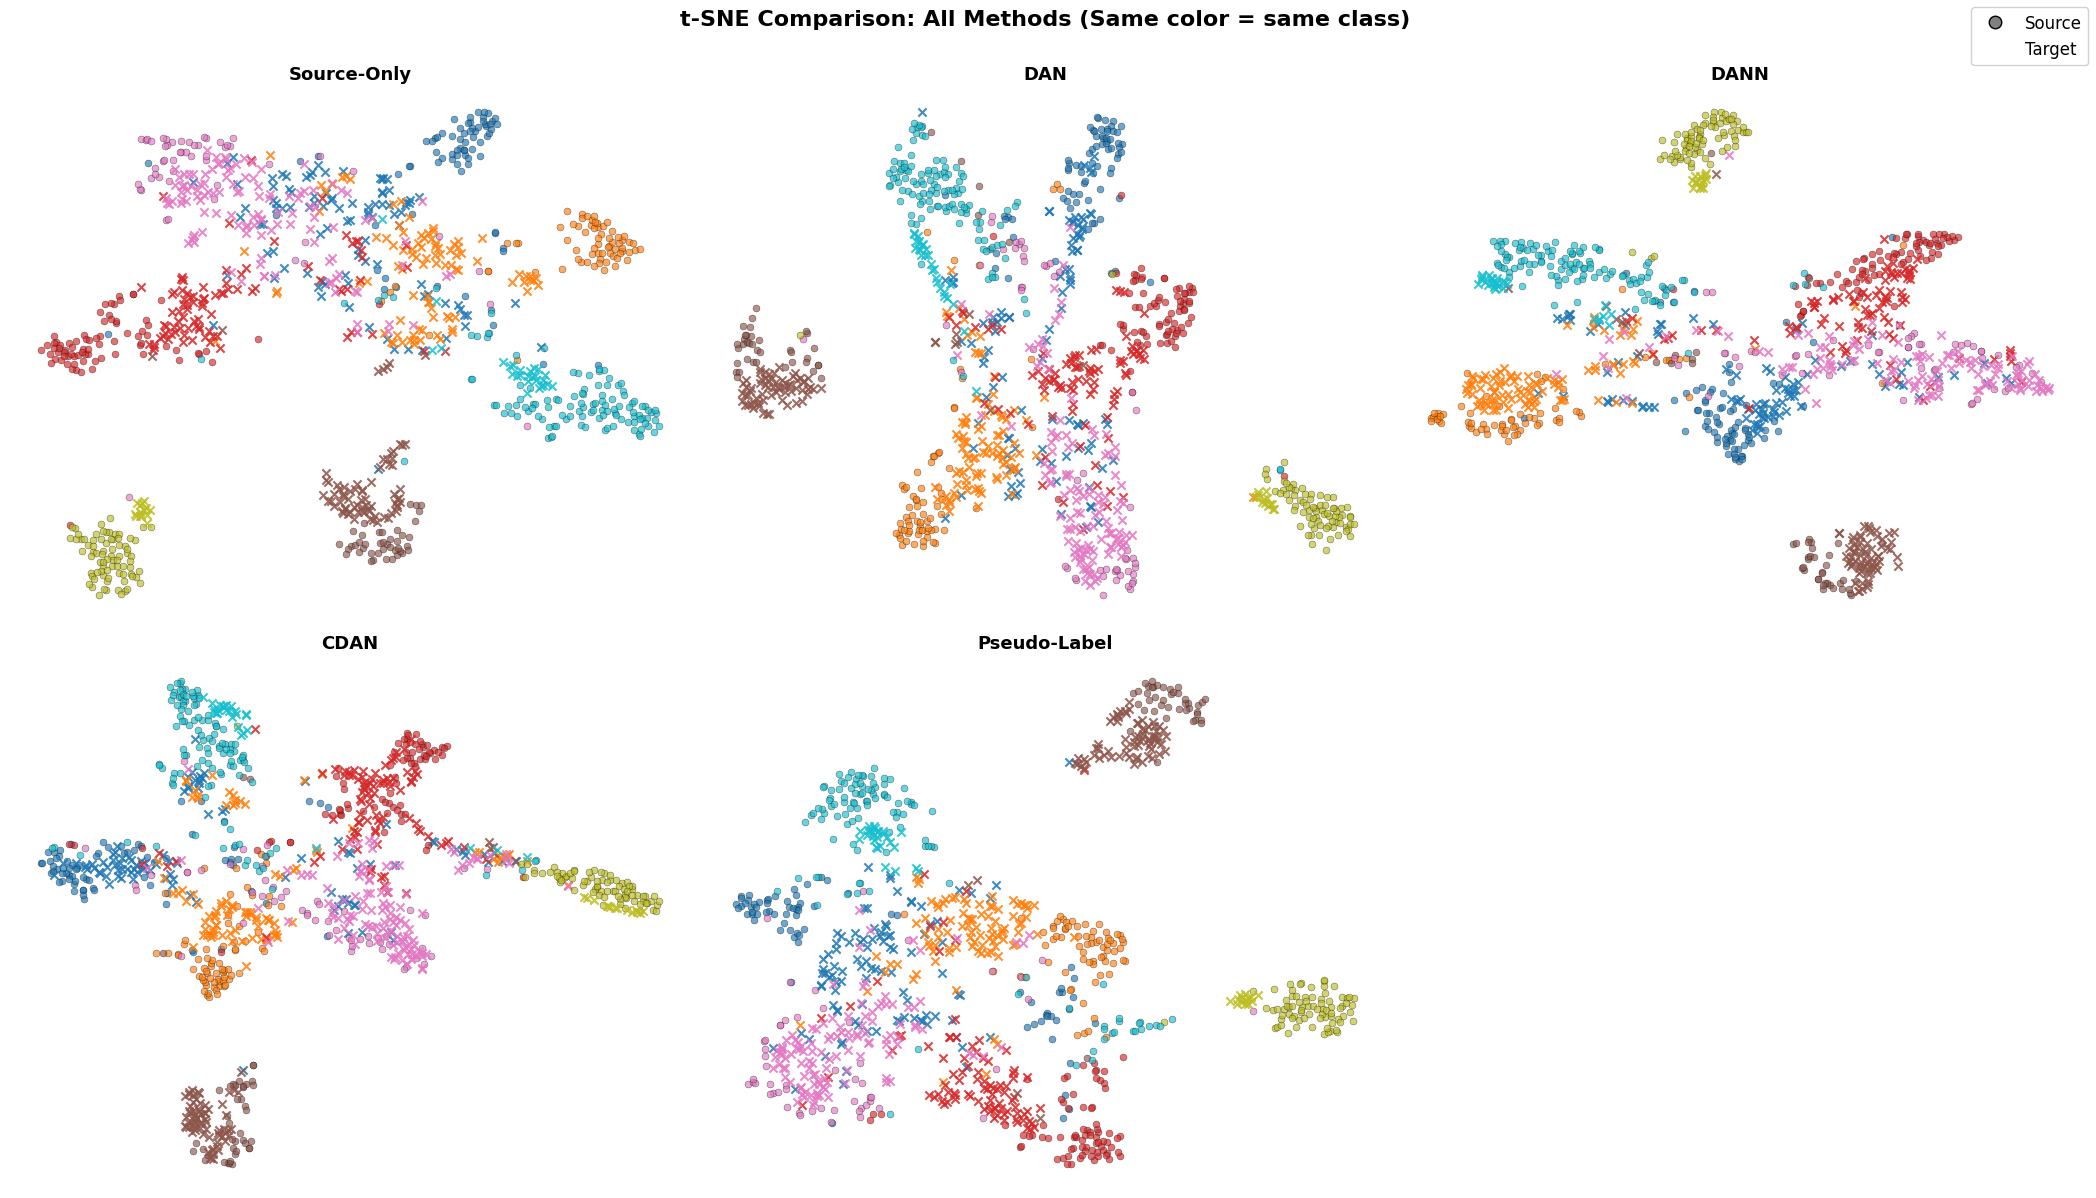


Creating Confusion Matrix Grid
Processing Source-Only (1/5)...
Processing DAN (2/5)...
Processing DANN (3/5)...
Processing CDAN (4/5)...
Processing Pseudo-Label (5/5)...
✓ Saved: viz_outputs/confusion_all_methods_grid.png


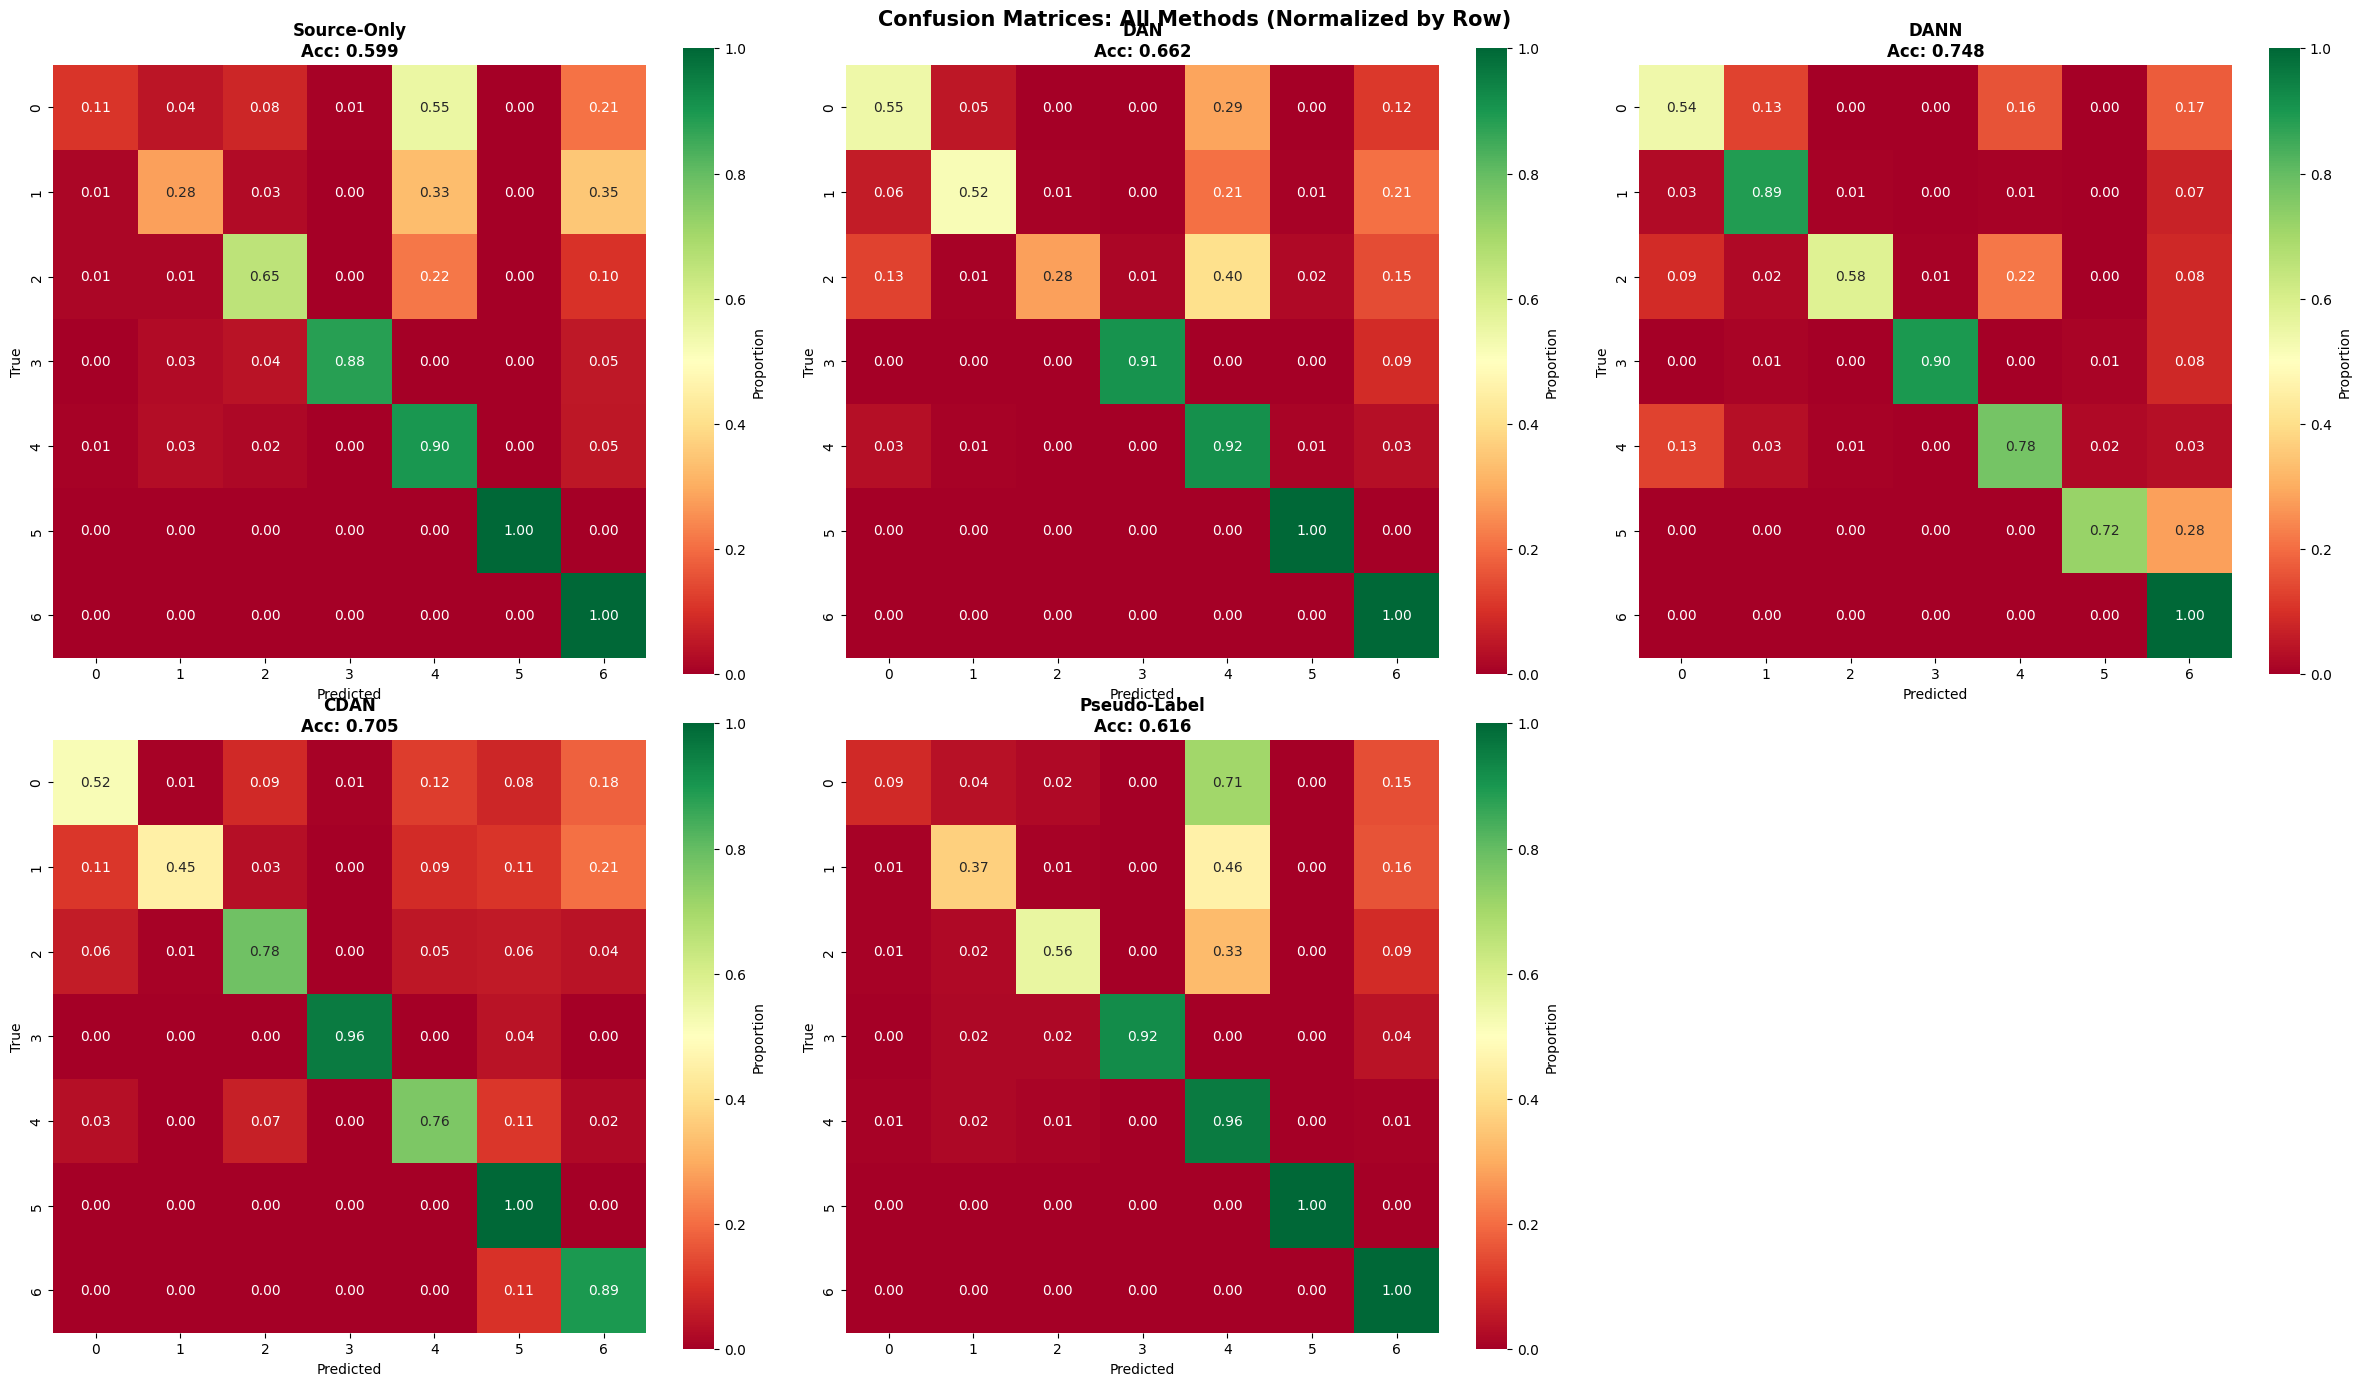


██████████████████████████████████████████████████████████████████████
PART 3: COMPARATIVE ANALYSES
██████████████████████████████████████████████████████████████████████

Creating Per-Class Accuracy Heatmap
Processing Source-Only...
Processing DAN...
Processing DANN...
Processing CDAN...
Processing Pseudo-Label...
✓ Saved: viz_outputs/per_class_accuracy_heatmap.png


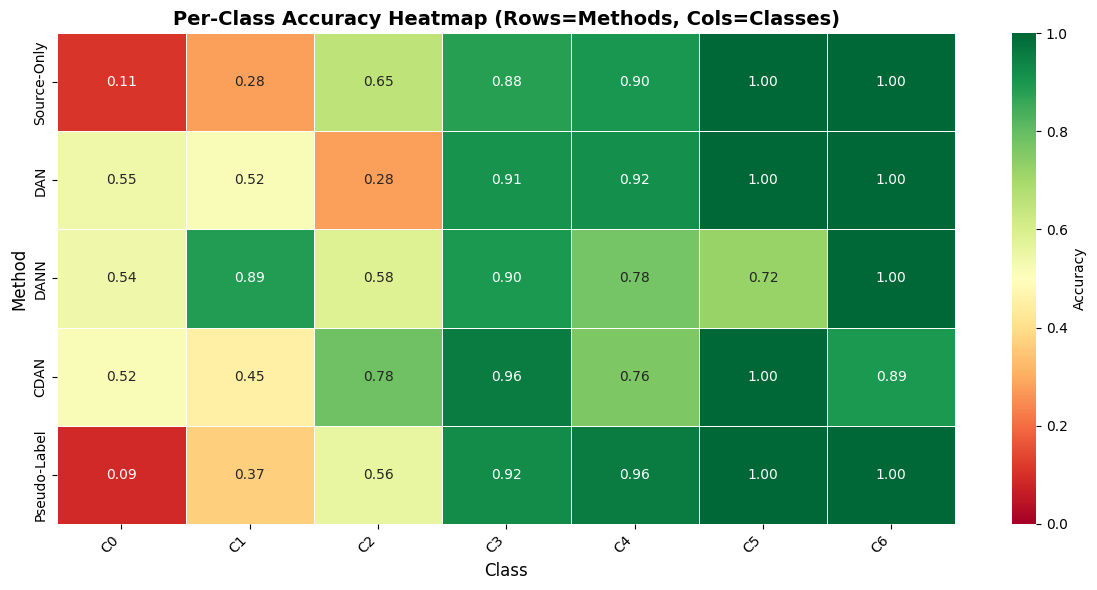


Comparing Performance on 3 Rarest Classes
Rarest 3 classes: [5 6 3]
Class counts: [ 18  38 118]
Evaluating Source-Only...
Evaluating DAN...
Evaluating DANN...
Evaluating CDAN...
Evaluating Pseudo-Label...
✓ Saved: viz_outputs/rare_class_comparison.png


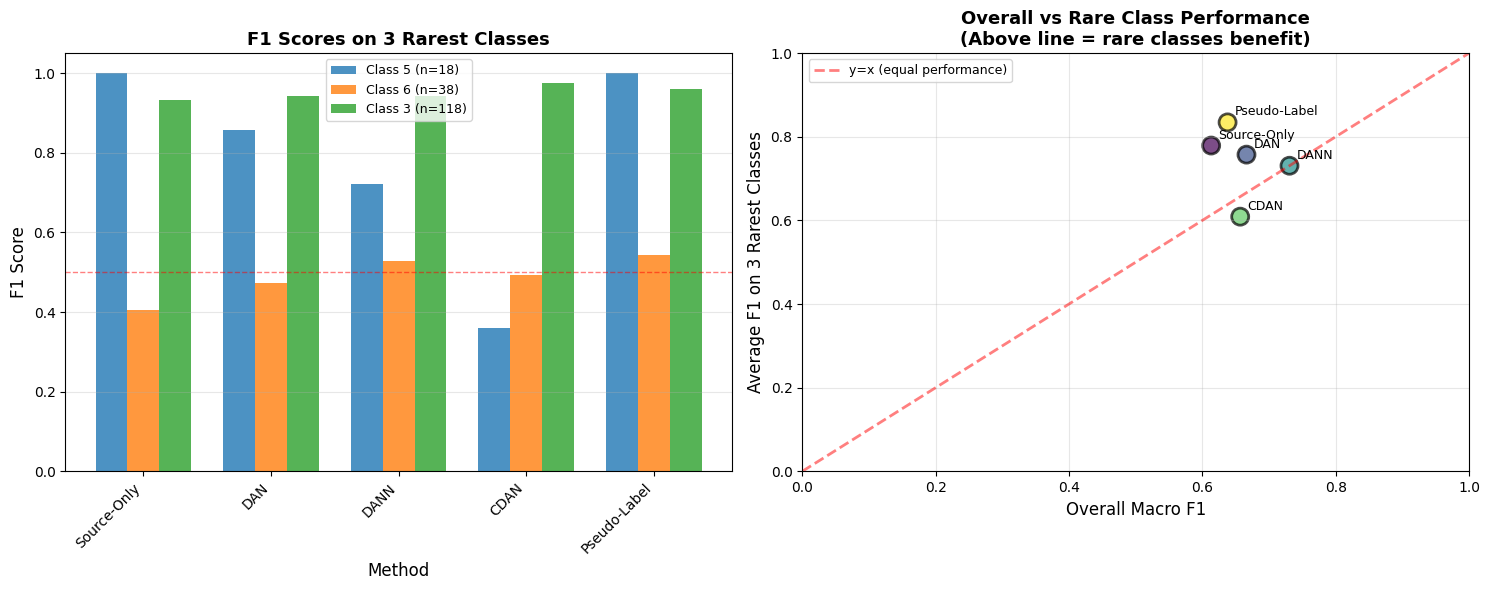


------------------------------------------------------------
RARE CLASS PERFORMANCE SUMMARY
------------------------------------------------------------
Source-Only          | Overall F1: 0.6133 | Rare Avg F1: 0.7790 | Diff: +0.1657
DAN                  | Overall F1: 0.6663 | Rare Avg F1: 0.7573 | Diff: +0.0910
DANN                 | Overall F1: 0.7308 | Rare Avg F1: 0.7307 | Diff: -0.0000
CDAN                 | Overall F1: 0.6568 | Rare Avg F1: 0.6090 | Diff: -0.0479
Pseudo-Label         | Overall F1: 0.6379 | Rare Avg F1: 0.8344 | Diff: +0.1965
------------------------------------------------------------

✓ COMPLETE VISUALIZATION SUITE FINISHED

All results saved to: viz_outputs/

Generated files:
  Per-model folders:
    - Source-Only/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
      ├── per_class_metrics.png
      └── metrics_summary.txt
    - DAN/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
 

In [57]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_p
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_p
    },
    source_dataset=source_test,
    target_dataset=target_test_dataset,
    source_test_loader=source_test_loader,
    target_test_loader=target_test_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='viz_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

### Analysis: Domain Adaptation Methods Comparison

**Key Findings:**
1. **DAN** (MMD-based): Statistical alignment reduces domain divergence
2. **DANN** (Adversarial): Learns domain-invariant features through adversarial training
3. **CDAN** (Class-aware): Conditions alignment on predictions to prevent negative transfer
4. **Pseudo-labeling**: Simple yet effective, leverages target structure

**Trade-offs Observed:**
- Alignment methods may slightly decrease source accuracy (discriminative features affected)
- Class-aware methods (CDAN) better preserve class boundaries
- Pseudo-labeling risk: confirmation bias on incorrect predictions

### 7.2. Summary till now + F1

In [58]:
classifiers_dict = {
    'Source-Only': cls_source,
    'DAN': cls_dan,
    'DANN': cls_dann,
    'CDAN': cls_cdan,
    'Pseudo-Label': cls_p
}

In [59]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"{'Method':<20} {'Source Acc (%)':<18} {'Target Acc (%)':<18} {'Gain (%)':<12}")
print("-"*70)

baseline_target = results['Source-Only']['target_acc']
for method, res in results.items():
    gain = res['target_acc'] - baseline_target
    print(f"{method:<20} {res['source_acc']:<18.2f} {res['target_acc']:<18.2f} {gain:+<12.2f}")
print("="*70 + "\n")


FINAL RESULTS SUMMARY
Method               Source Acc (%)     Target Acc (%)     Gain (%)    
----------------------------------------------------------------------
Source-Only          95.47              60.43              0.00++++++++
DAN                  90.02              66.16              5.73++++++++
DANN                 92.42              74.81              14.38+++++++
CDAN                 88.95              70.48              10.05+++++++
Pseudo-Label         90.27              62.47              2.04++++++++



In [60]:
# def compute_class_metrics(models_dict, classifiers, target_test_loader):
#     results_per_class = {}

#     for name, model in models_dict.items():
#         classifier = classifiers[name]
#         _, preds, labels, _ = evaluate(model, classifier, target_test_loader)

#         f1_per_class = f1_score(labels, preds, average=None, zero_division=0)
#         results_per_class[name] = f1_per_class

#     return results_per_class

# print("Computing per-class F1 scores...")
# f1_results = compute_class_metrics(models, classifiers_dict, target_test_loader)

In [61]:
# Find 3 rarest classes in target
# target_labels_all = []
# for _, labels in target_test_loader:
#     target_labels_all.extend(labels.numpy())
# target_labels_all = np.array(target_labels_all)

# class_counts = np.bincount(target_labels_all, minlength=NUM_CLASSES)
# rarest_classes = np.argsort(class_counts)[:3]

# print("\n" + "="*70)
# print("F1 SCORES FOR 3 RAREST CLASSES")
# print("="*70)
# print(f"Rarest classes: {rarest_classes} with counts: {class_counts[rarest_classes]}")
# print("-"*70)
# print(f"{'Method':<20}", end='')
# for cls_idx in rarest_classes:
#     print(f"Class {cls_idx:<10}", end='')
# print("Average")
# print("-"*70)

# for name, f1_scores in f1_results.items():
#     print(f"{name:<20}", end='')
#     rare_f1s = []
#     for cls_idx in rarest_classes:
#         f1_val = f1_scores[cls_idx]
#         rare_f1s.append(f1_val)
#         print(f"{f1_val:<10.4f}", end='')
#     print(f"{np.mean(rare_f1s):.4f}")
# print("="*70 + "\n")


In [62]:
# heatmap_path = os.path.join(exp_dir, f"{exp_name}_perclass_heatmap.png")
# plot_per_class_heatmap(models, classifiers_dict, target_loader, NUM_CLASSES)

### t-SNE Analysis

**Observations:**
- **Source-Only**: Clear separation between source (blue) and target (red) - domains not aligned
- **DAN/DANN/CDAN**: Reduced separation - domains becoming more aligned
- **Best alignment**: Look for overlap while preserving class clusters
- **Class-aware methods** (CDAN) should maintain better class separation

In [63]:
import shutil

shutil.make_archive('/kaggle/working/viz_outputs', 'zip', 'viz_outputs')


'/kaggle/working/viz_outputs.zip'

## 8. Experiment 4: Concept Shift Simulation
Simulate label/concept shift by modifying target class distribution

In [64]:
training_functions = {
    "Source Only": train_source_only,     # Baseline model trained only on source
    "DAN": train_dan,                     # Deep Adaptation Network (MMD-based)
    "DANN": train_dann,                   # Domain-Adversarial Neural Network
    "CDAN": train_cdan,                   # Conditional Domain-Adversarial Network
    "Self-Training": safe_self_training,  # Pseudo-label/self-training variant
}

### 8.1 rare class scenario

In [73]:
# def create_rare_class_dataset(dataset, rare_class, reduction_ratio=0.2):
#     """Return a copy of dataset with one class underrepresented."""
#     samples = []
#     rare_samples = [s for s in dataset.samples if s[1] == rare_class]
#     non_rare_samples = [s for s in dataset.samples if s[1] != rare_class]

#     reduced_rare = random.sample(rare_samples, max(1, int(len(rare_samples) * reduction_ratio)))
#     samples.extend(non_rare_samples)
#     samples.extend(reduced_rare)
#     print(f"Rare-class {rare_class}: kept {len(reduced_rare)}/{len(rare_samples)} samples")

#     rare_dataset = copy.deepcopy(dataset)
#     rare_dataset.samples = samples
#     return rare_dataset

import random
import copy

def create_rare_class_dataset(dataset, rare_class, reduction_ratio=0.2):
    """Return a dataset where one class (rare_class) is underrepresented."""
    
    # Handle both Subset and normal dataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    
    # Collect samples and labels
    samples = []
    for idx in indices:
        item = base_dataset[idx]
        samples.append((idx, item[1]))  # (index, label)
    
    # Separate rare vs non-rare
    rare_indices = [idx for idx, label in samples if label == rare_class]
    non_rare_indices = [idx for idx, label in samples if label != rare_class]
    
    reduced_rare = random.sample(rare_indices, max(1, int(len(rare_indices) * reduction_ratio)))
    final_indices = non_rare_indices + reduced_rare
    
    print(f"Rare-class {rare_class}: kept {len(reduced_rare)}/{len(rare_indices)} samples")

    # Create a new Subset dataset
    rare_dataset = torch.utils.data.Subset(base_dataset, final_indices)
    return rare_dataset


In [74]:
# Identify rarest class (for your rare-class test)
class_counts = {}
# for _, label in target_train.indices:
#     class_counts[label] = class_counts.get(label, 0) + 1
# class_counts = {}
# for idx in target_train.indices:
#     _, label = full_target.samples[idx]
#     class_counts[label] = class_counts.get(label, 0) + 1
# rarest_classes = sorted(class_counts, key=class_counts.get)
rare_class = 3
# rarest_classes[0]

# Rare class dataset (20% of its original samples)
target_rare = create_rare_class_dataset(target_test_dataset, rare_class, reduction_ratio=0.2)
target_rare_loader = DataLoader(target_rare, batch_size=32, shuffle=True, num_workers=4)

Rare-class 3: kept 23/118 samples


In [75]:
shifted_results_rare = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    classifier = classifiers_dict[name]
    acc, preds, labels, _ = evaluate(model, classifier, target_rare_loader)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)

    shifted_results_rare[name] = {'accuracy': acc, 'f1_macro': f1_macro}
    print(f"{name:<20} Accuracy: {acc:.2f}%, F1-Macro: {f1_macro:.4f}")


Evaluating Source-Only...
Source-Only          Accuracy: 56.01%, F1-Macro: 0.6137

Evaluating DAN...
DAN                  Accuracy: 62.81%, F1-Macro: 0.6660

Evaluating DANN...
DANN                 Accuracy: 72.79%, F1-Macro: 0.7375

Evaluating CDAN...
CDAN                 Accuracy: 67.15%, F1-Macro: 0.6602

Evaluating Pseudo-Label...
Pseudo-Label         Accuracy: 57.31%, F1-Macro: 0.6405



COMPLETE VISUALIZATION SUITE
Number of methods: 5
Output directory: rare_outputs


██████████████████████████████████████████████████████████████████████
PART 1: PER-MODEL DETAILED VISUALIZATIONS
██████████████████████████████████████████████████████████████████████

Visualizing: Source-Only
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/Source-Only/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DAN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/DAN/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DANN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/

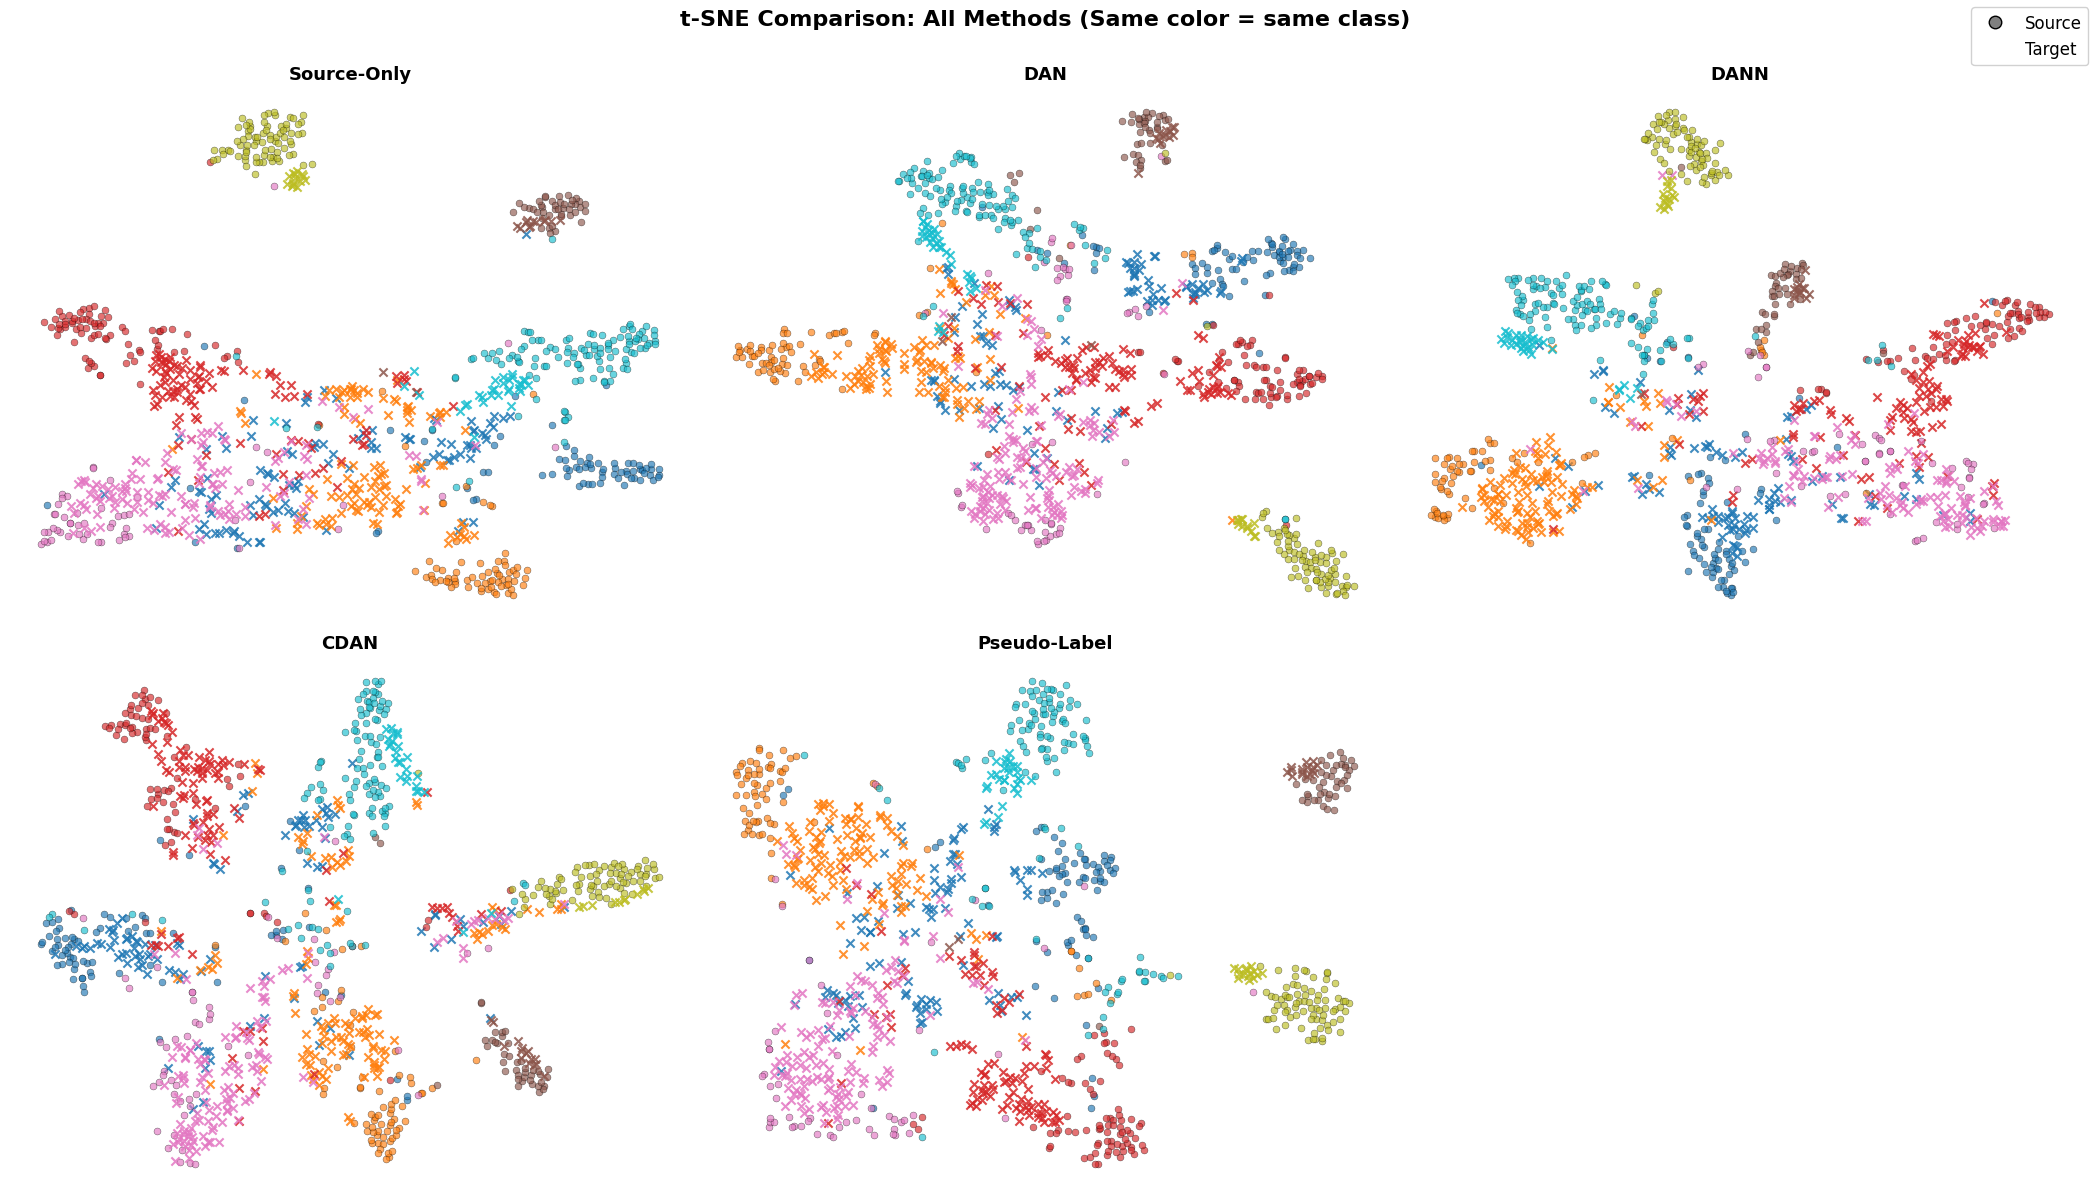


Creating Confusion Matrix Grid
Processing Source-Only (1/5)...
Processing DAN (2/5)...
Processing DANN (3/5)...
Processing CDAN (4/5)...
Processing Pseudo-Label (5/5)...
✓ Saved: rare_outputs/confusion_all_methods_grid.png


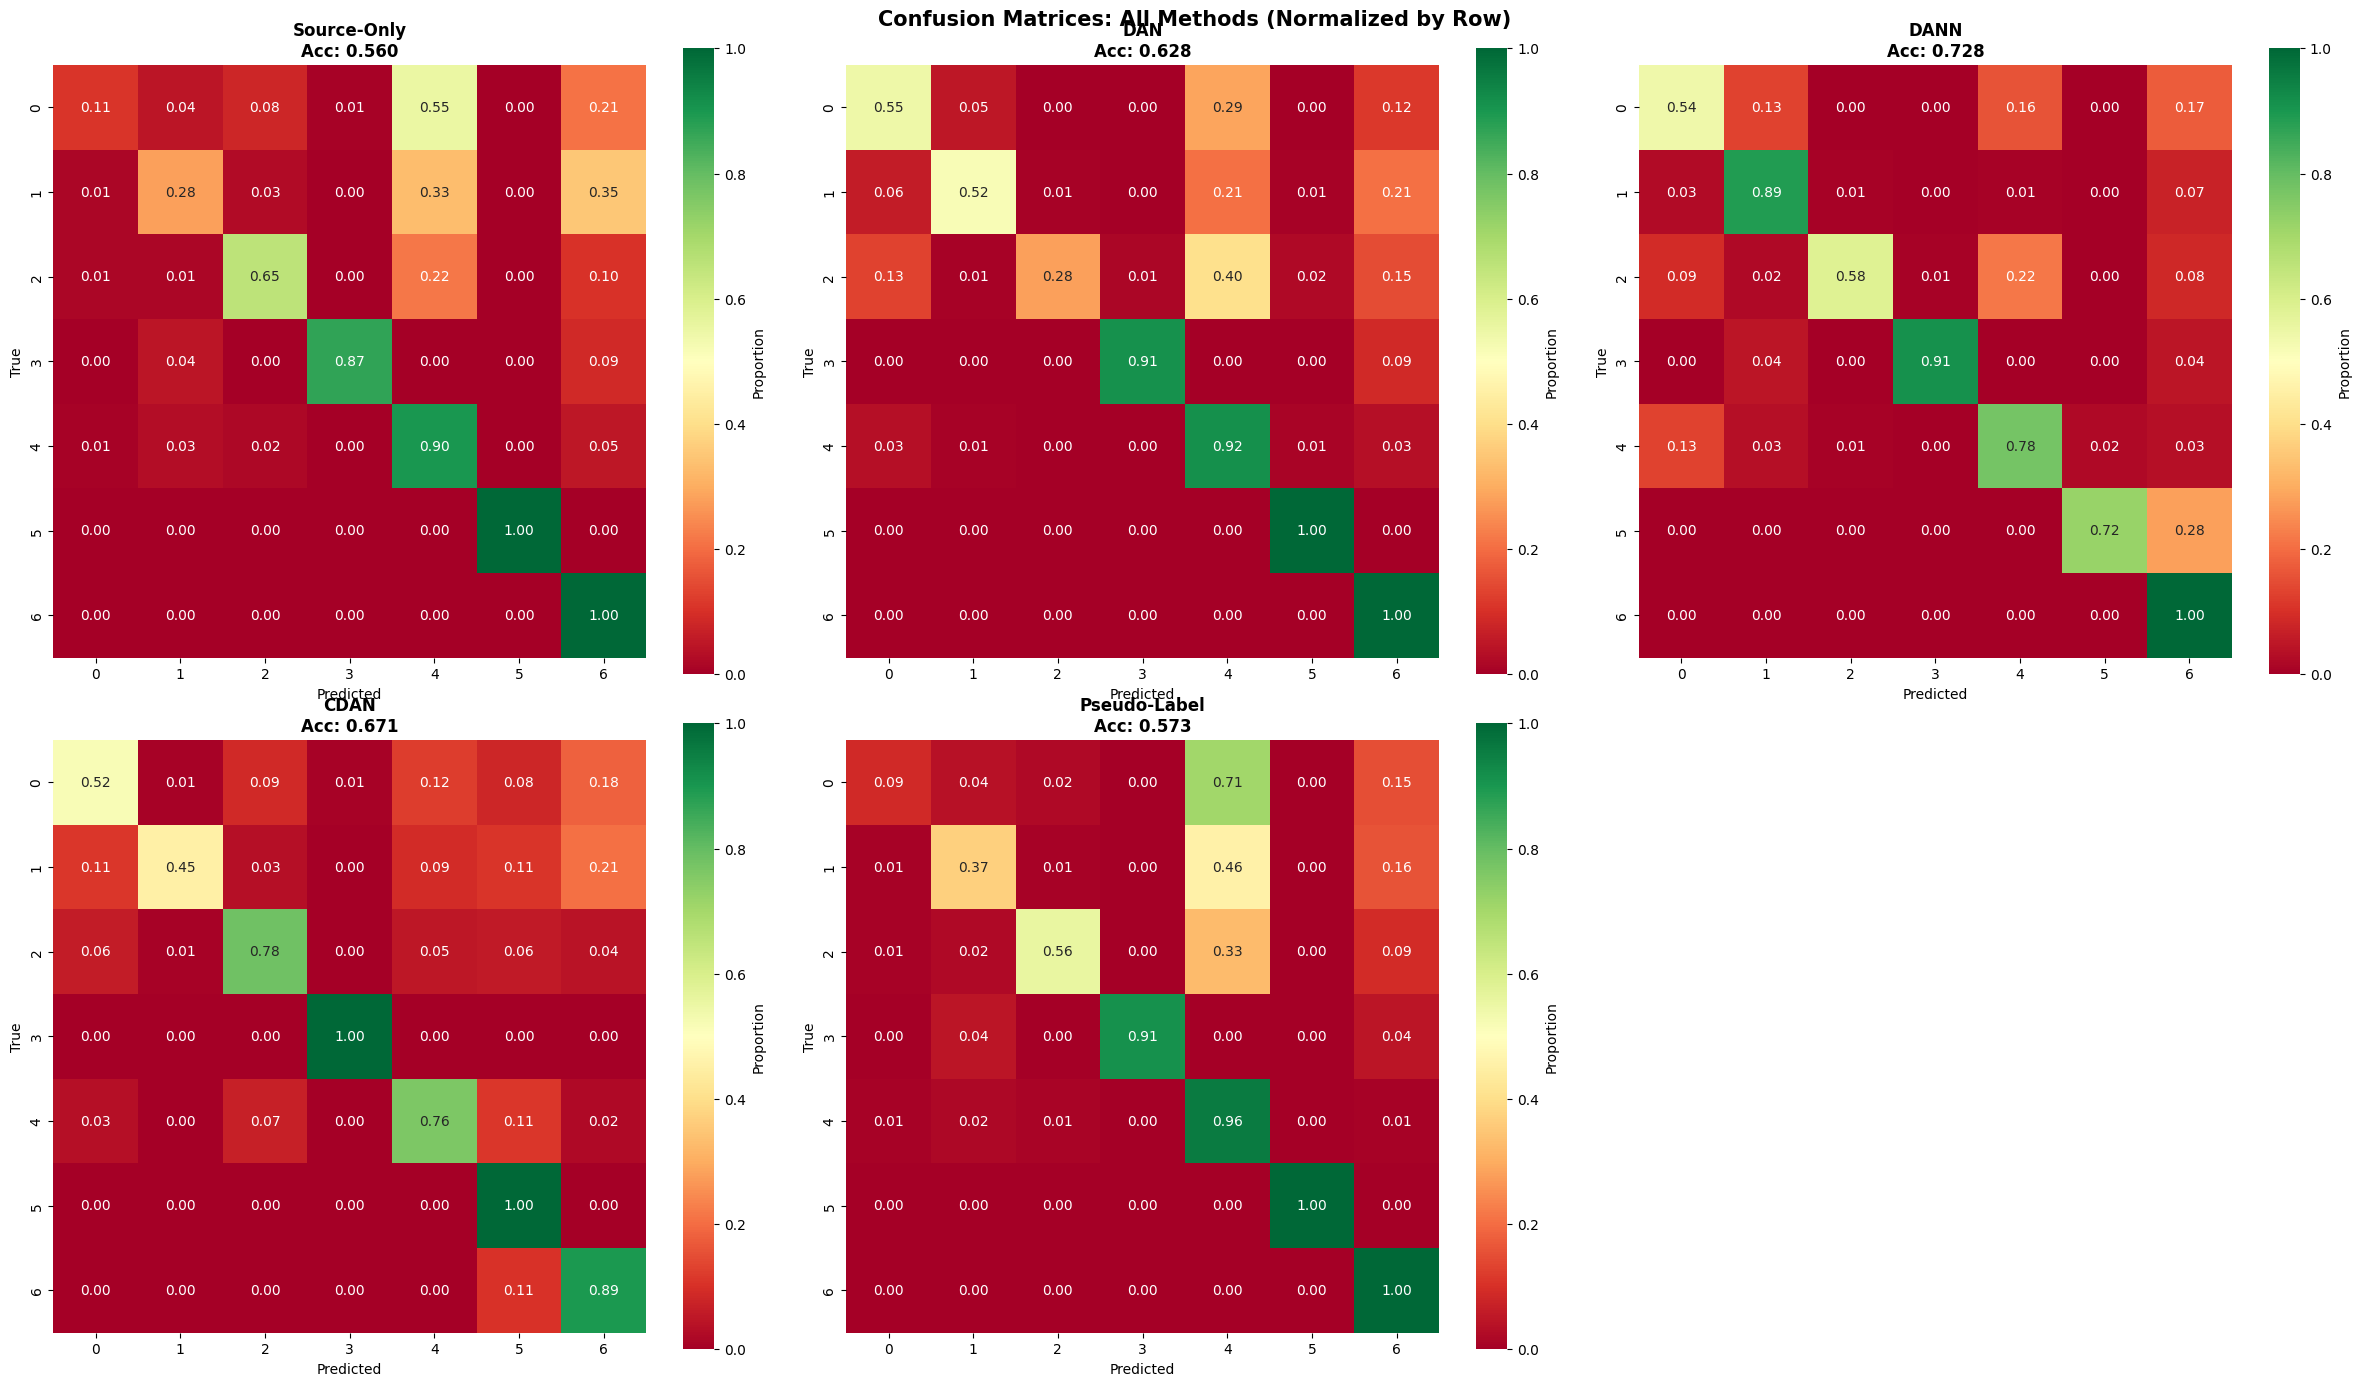


██████████████████████████████████████████████████████████████████████
PART 3: COMPARATIVE ANALYSES
██████████████████████████████████████████████████████████████████████

Creating Per-Class Accuracy Heatmap
Processing Source-Only...
Processing DAN...
Processing DANN...
Processing CDAN...
Processing Pseudo-Label...
✓ Saved: rare_outputs/per_class_accuracy_heatmap.png


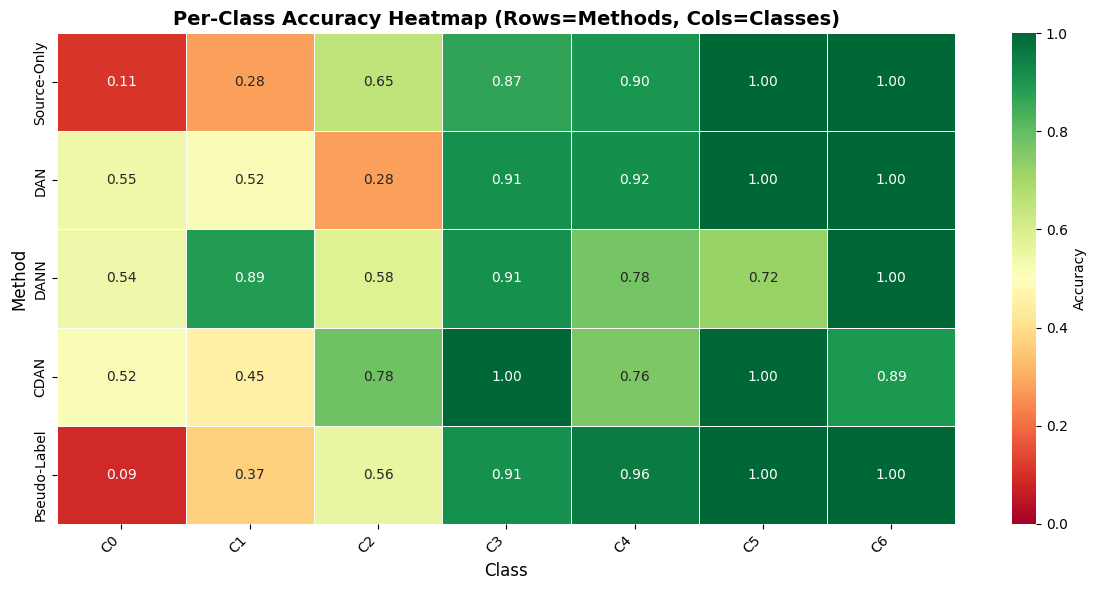


Comparing Performance on 3 Rarest Classes
Rarest 3 classes: [5 3 6]
Class counts: [18 23 38]
Evaluating Source-Only...
Evaluating DAN...
Evaluating DANN...
Evaluating CDAN...
Evaluating Pseudo-Label...
✓ Saved: rare_outputs/rare_class_comparison.png


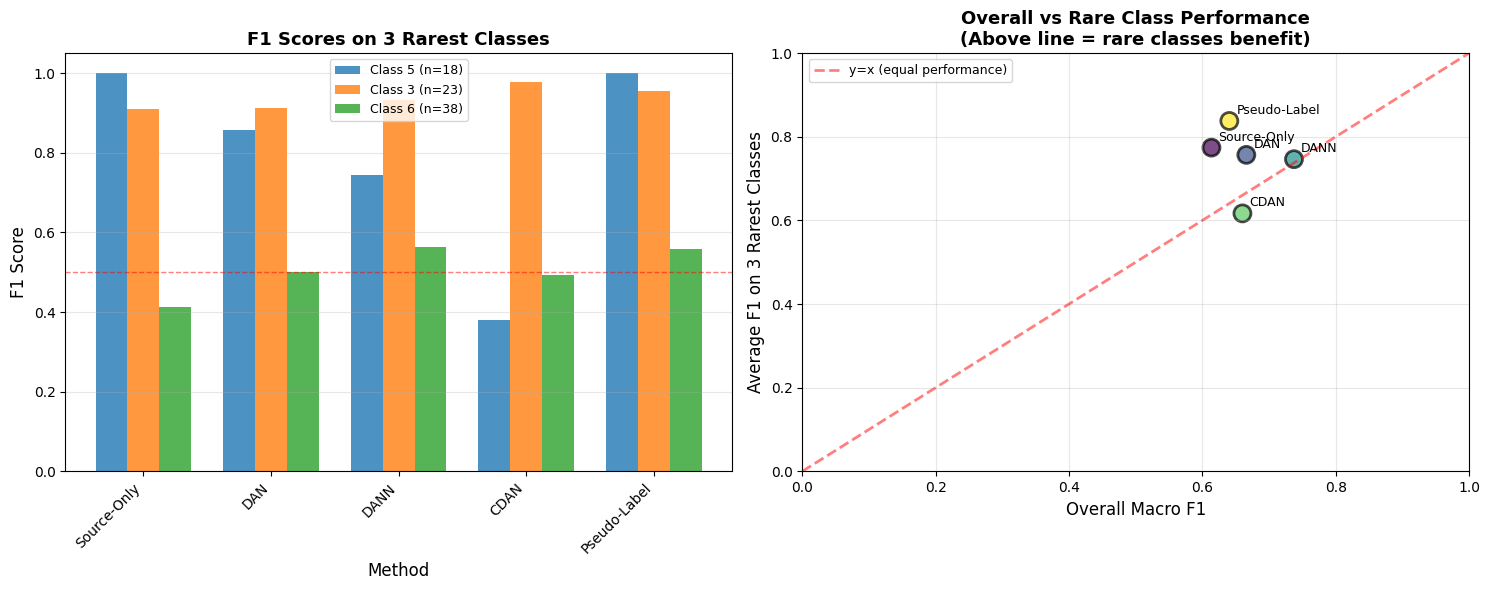


------------------------------------------------------------
RARE CLASS PERFORMANCE SUMMARY
------------------------------------------------------------
Source-Only          | Overall F1: 0.6137 | Rare Avg F1: 0.7740 | Diff: +0.1603
DAN                  | Overall F1: 0.6660 | Rare Avg F1: 0.7567 | Diff: +0.0907
DANN                 | Overall F1: 0.7375 | Rare Avg F1: 0.7464 | Diff: +0.0089
CDAN                 | Overall F1: 0.6602 | Rare Avg F1: 0.6168 | Diff: -0.0434
Pseudo-Label         | Overall F1: 0.6405 | Rare Avg F1: 0.8378 | Diff: +0.1973
------------------------------------------------------------

✓ COMPLETE VISUALIZATION SUITE FINISHED

All results saved to: rare_outputs/

Generated files:
  Per-model folders:
    - Source-Only/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
      ├── per_class_metrics.png
      └── metrics_summary.txt
    - DAN/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png


In [76]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_p
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_p
    },
    source_dataset=source_train,
    target_dataset=target_rare,
    source_test_loader=source_test_loader,
    target_test_loader=target_rare_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='rare_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

In [77]:
import shutil

shutil.make_archive('/kaggle/working/rare_outputs', 'zip', 'rare_outputs')

'/kaggle/working/rare_outputs.zip'

### 8.2: Label Shift

In [83]:
# def create_label_shift_dataset(dataset, classes_to_remove):
#     """Return dataset with certain classes completely removed."""
#     filtered_samples = [s for s in dataset.samples if s[1] not in classes_to_remove]
#     print(f"Label shift: removed classes {classes_to_remove}, kept {len(filtered_samples)}/{len(dataset.samples)} samples")

#     shifted_dataset = copy.deepcopy(dataset)
#     shifted_dataset.samples = filtered_samples
#     return shifted_dataset

import copy
import torch

def create_label_shift_dataset(dataset, classes_to_remove):
    """Return dataset with certain classes completely removed."""
    
    # Handle both Subset and normal dataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    
    # Keep only samples whose label is NOT in classes_to_remove
    kept_indices = []
    for idx in indices:
        _, label = base_dataset[idx]
        if label not in classes_to_remove:
            kept_indices.append(idx)
    
    print(f"Label shift: removed classes {classes_to_remove}, kept {len(kept_indices)}/{len(indices)} samples")

    shifted_dataset = torch.utils.data.Subset(base_dataset, kept_indices)
    return shifted_dataset

classes_to_remove = 2, 3, 5
# rarest_classes[5, 15, 37]
target_label_shift = create_label_shift_dataset(target_test_dataset, classes_to_remove)
target_label_shift_loader = DataLoader(target_label_shift, batch_size=32, shuffle=True, num_workers=4)

print(f"\nOriginal target samples: {len(target_test_dataset)}")
print(f"Shifted target samples: {len(target_label_shift)}")


Label shift: removed classes (2, 3, 5), kept 506/786 samples

Original target samples: 786
Shifted target samples: 506


In [84]:
print("\nTraining on Label-Shifted Target Domain...")
print("-"*70)

label_shift_models, label_shift_classifiers = {}, {}
shifted_results_label = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    classifier = classifiers_dict[name]
    acc, preds, labels, _ = evaluate(model, classifier, target_label_shift_loader)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)

    shifted_results_label[name] = {'accuracy': acc, 'f1_macro': f1_macro}
    print(f"{name:<20} Accuracy: {acc:.2f}%, F1-Macro: {f1_macro:.4f}")

print("-"*70)


Training on Label-Shifted Target Domain...
----------------------------------------------------------------------

Evaluating Source-Only...
Source-Only          Accuracy: 50.40%, F1-Macro: 0.2910

Evaluating DAN...
DAN                  Accuracy: 70.16%, F1-Macro: 0.4499

Evaluating DANN...
DANN                 Accuracy: 76.09%, F1-Macro: 0.4922

Evaluating CDAN...
CDAN                 Accuracy: 61.26%, F1-Macro: 0.3624

Evaluating Pseudo-Label...
Pseudo-Label         Accuracy: 54.74%, F1-Macro: 0.3927
----------------------------------------------------------------------



COMPLETE VISUALIZATION SUITE
Number of methods: 5
Output directory: label_shift_outputs


██████████████████████████████████████████████████████████████████████
PART 1: PER-MODEL DETAILED VISUALIZATIONS
██████████████████████████████████████████████████████████████████████

Visualizing: Source-Only
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: label_shift_outputs/Source-Only/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DAN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: label_shift_outputs/DAN/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DANN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations sa

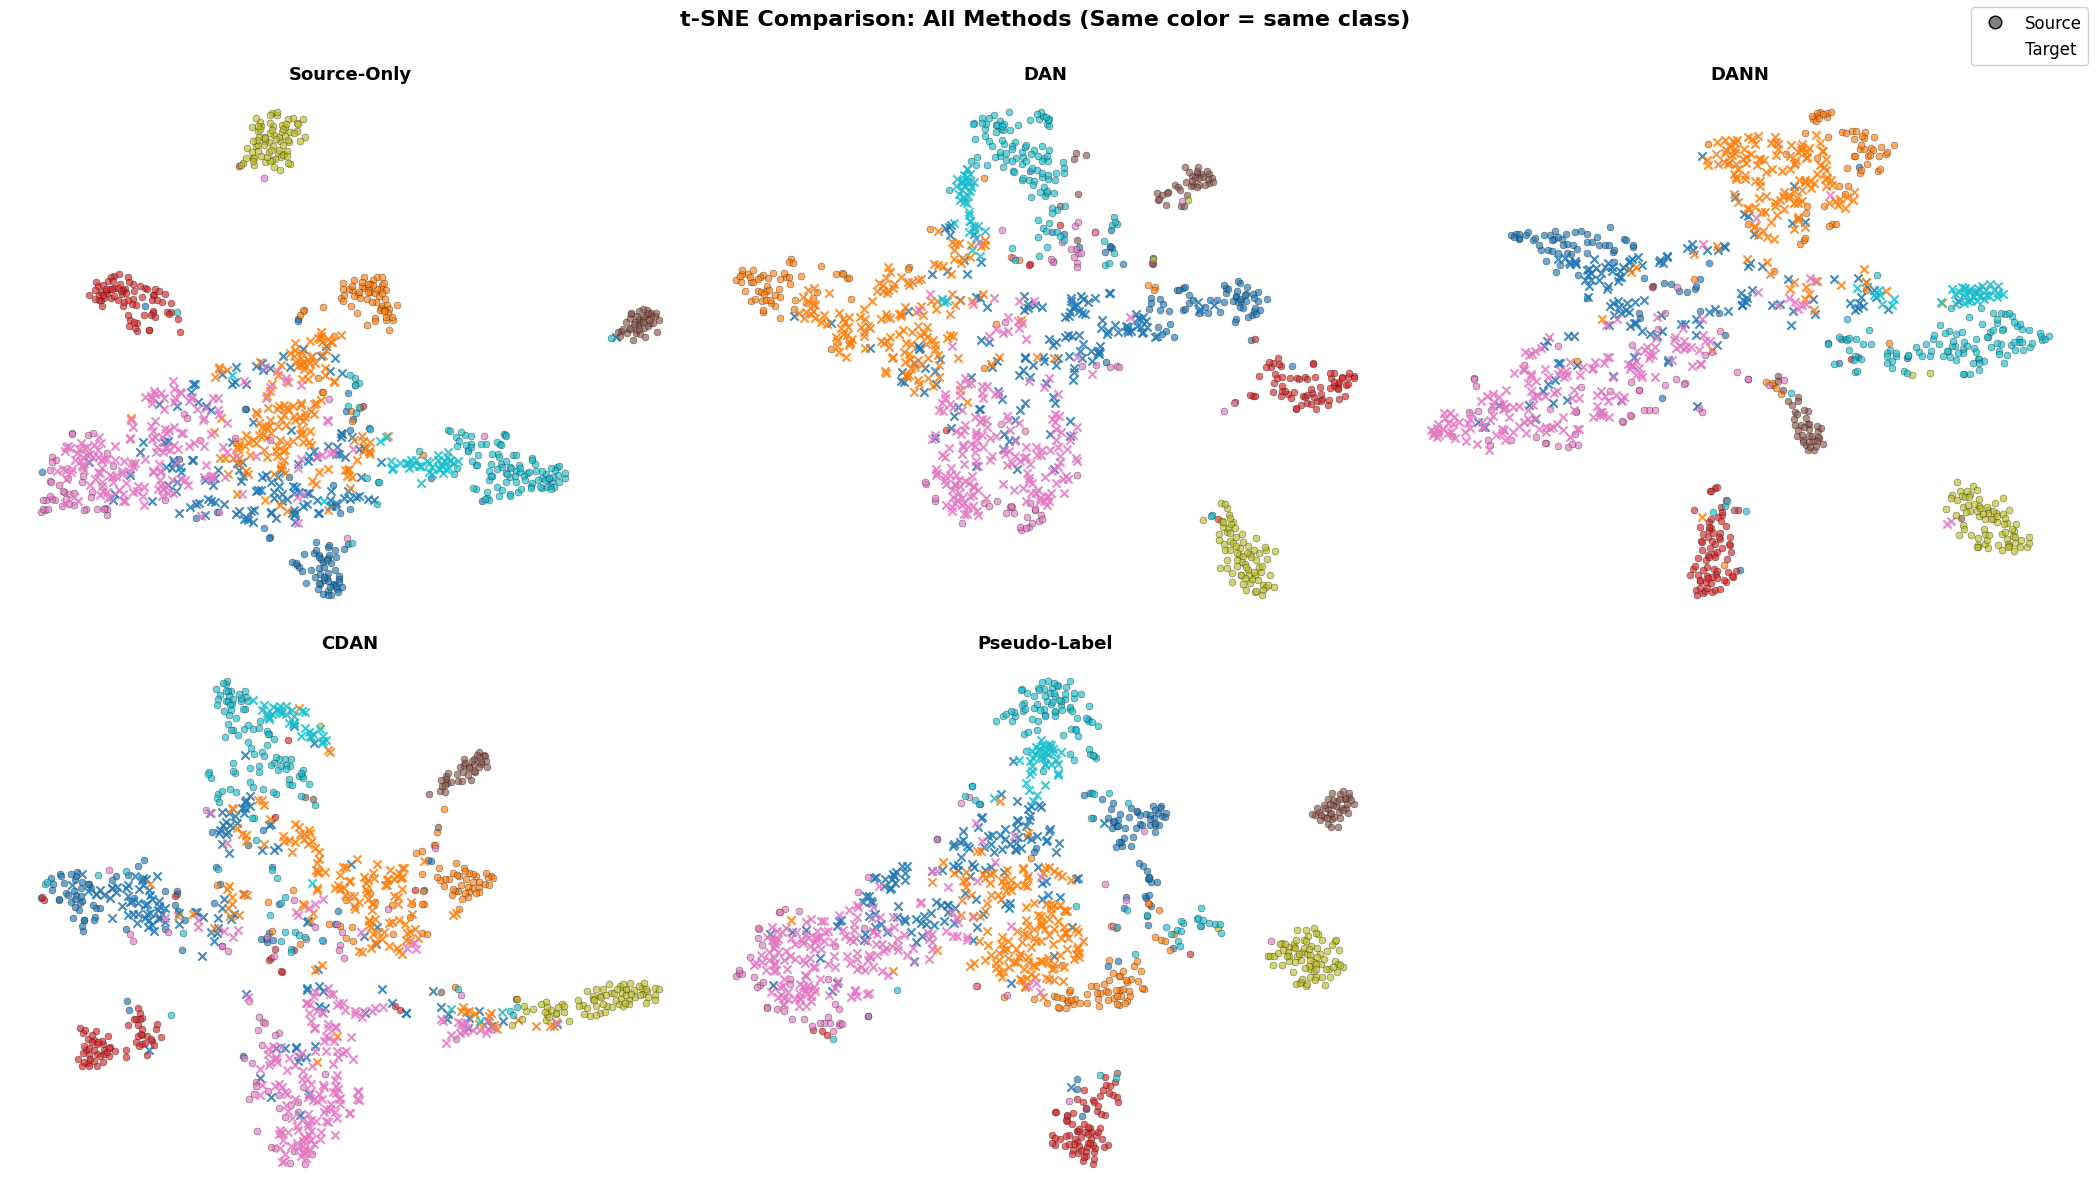


Creating Confusion Matrix Grid
Processing Source-Only (1/5)...
Processing DAN (2/5)...
Processing DANN (3/5)...
Processing CDAN (4/5)...
Processing Pseudo-Label (5/5)...
✓ Saved: label_shift_outputs/confusion_all_methods_grid.png


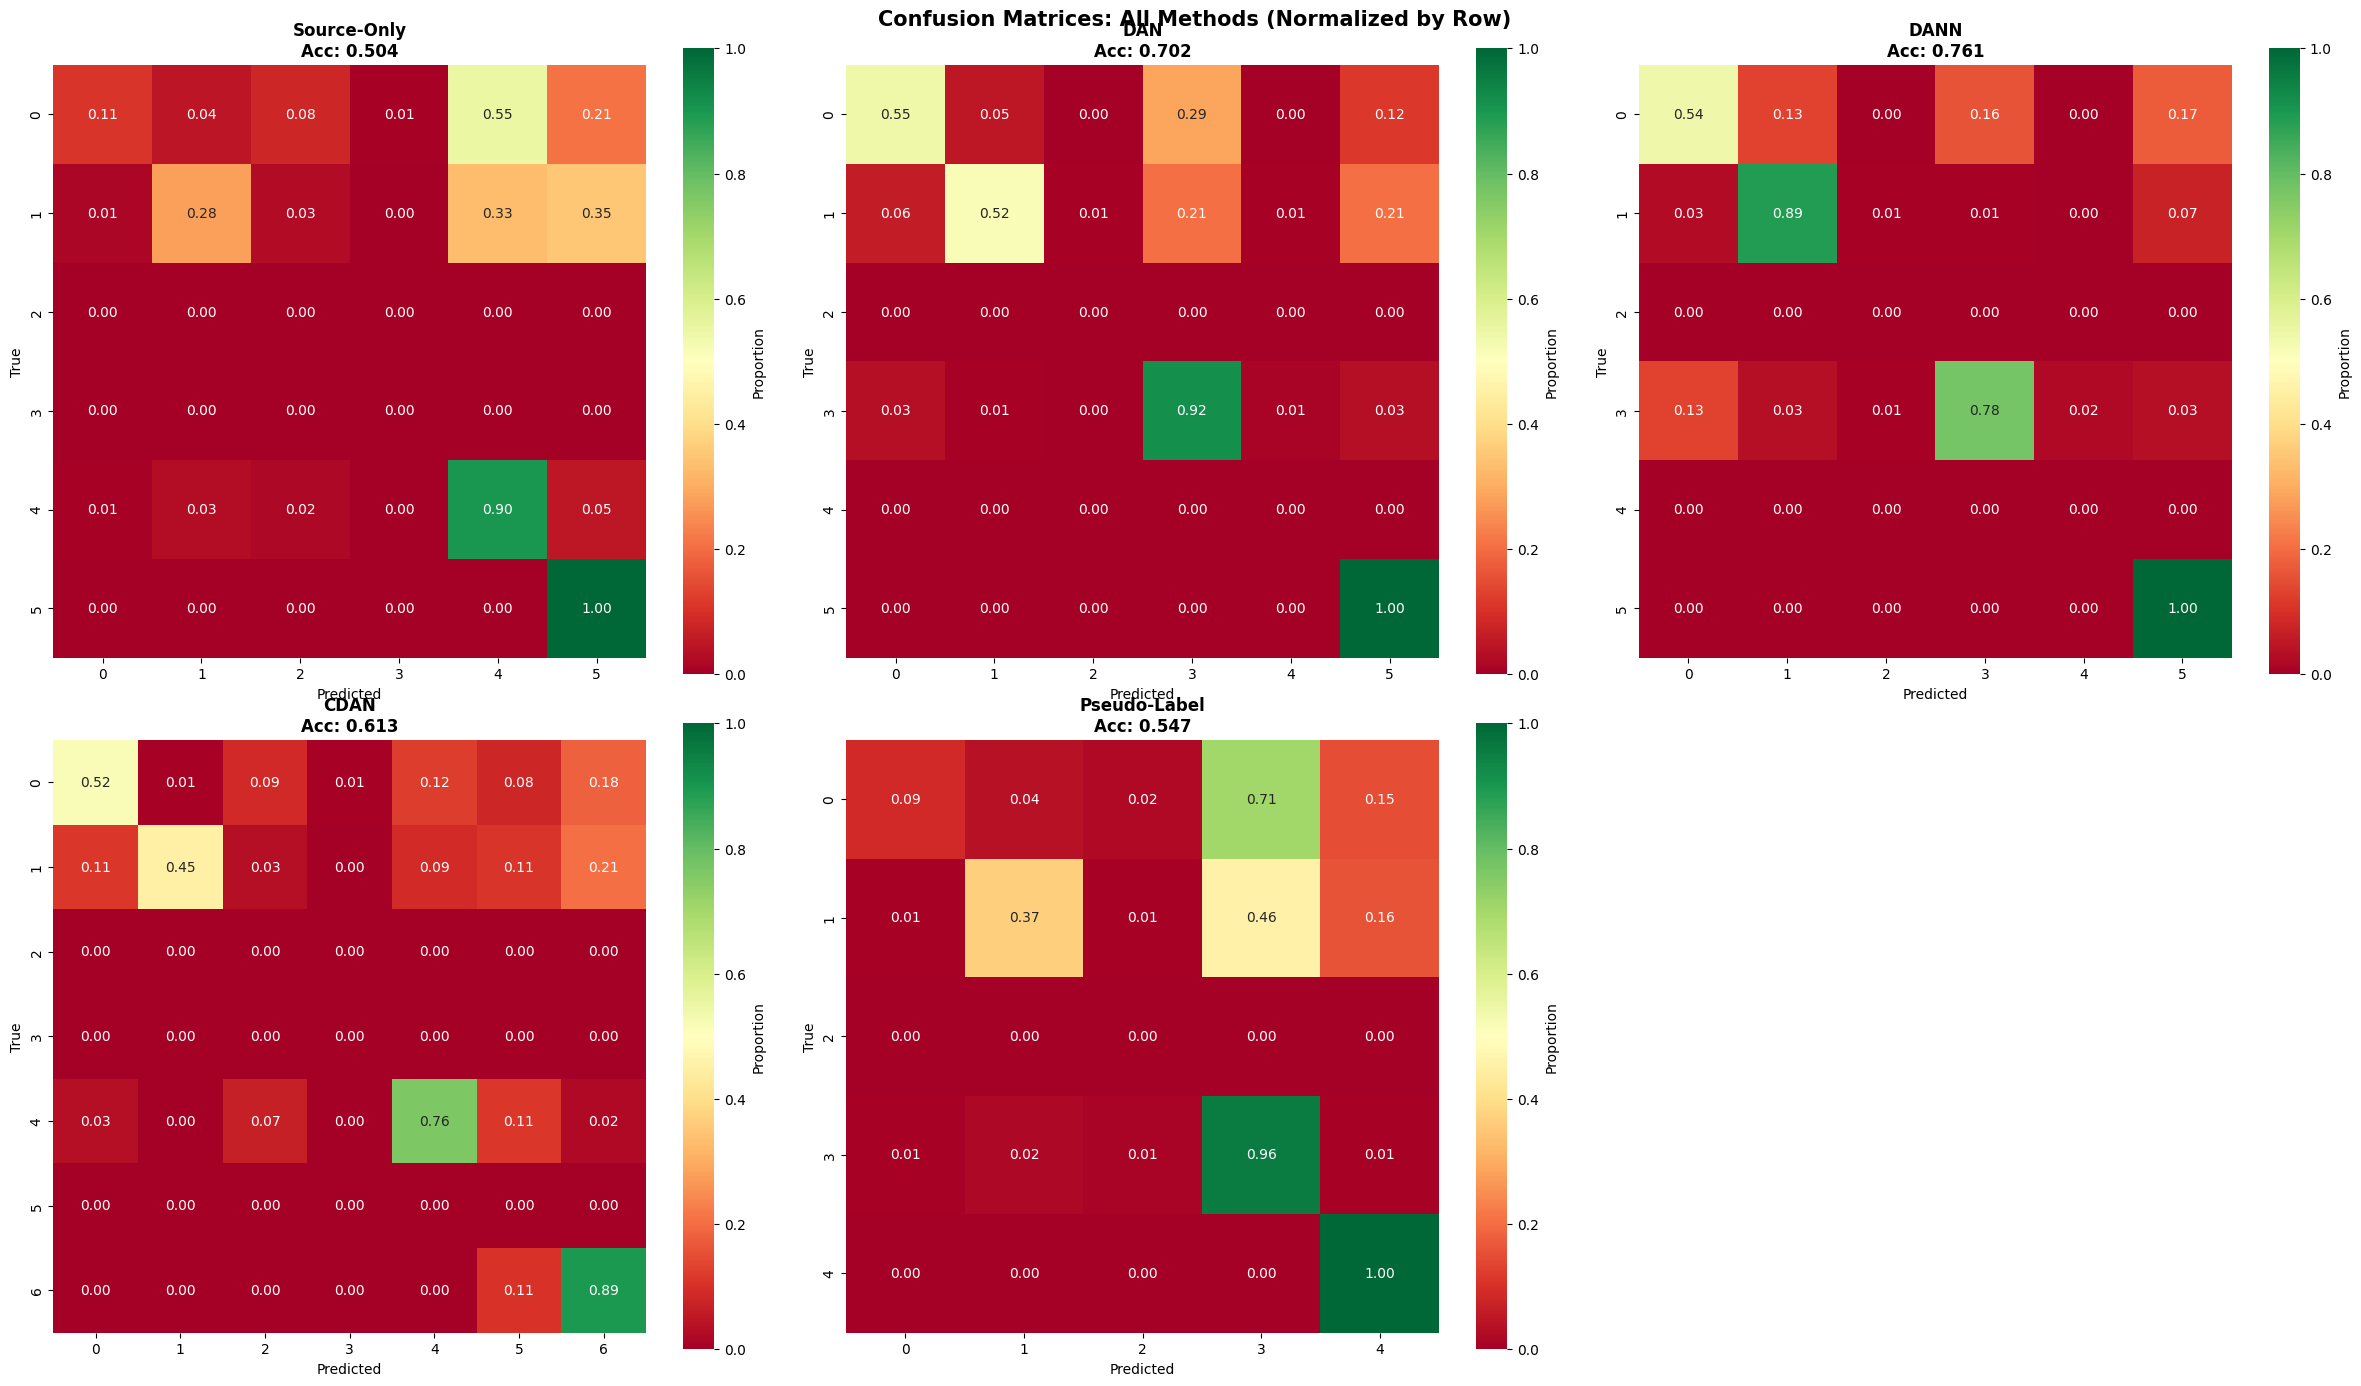


██████████████████████████████████████████████████████████████████████
PART 3: COMPARATIVE ANALYSES
██████████████████████████████████████████████████████████████████████

Creating Per-Class Accuracy Heatmap
Processing Source-Only...
Processing DAN...
Processing DANN...
Processing CDAN...
Processing Pseudo-Label...
✓ Saved: label_shift_outputs/per_class_accuracy_heatmap.png


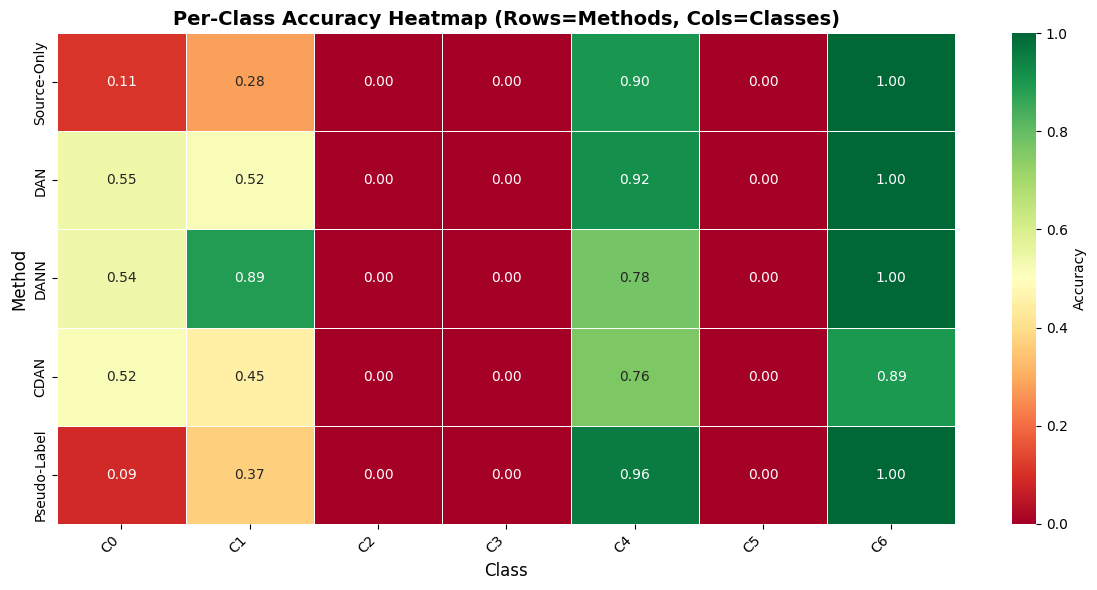


Comparing Performance on 3 Rarest Classes
Rarest 3 classes: [3 2 5]
Class counts: [0 0 0]
Evaluating Source-Only...
Evaluating DAN...
Evaluating DANN...
Evaluating CDAN...
Evaluating Pseudo-Label...
✓ Saved: label_shift_outputs/rare_class_comparison.png


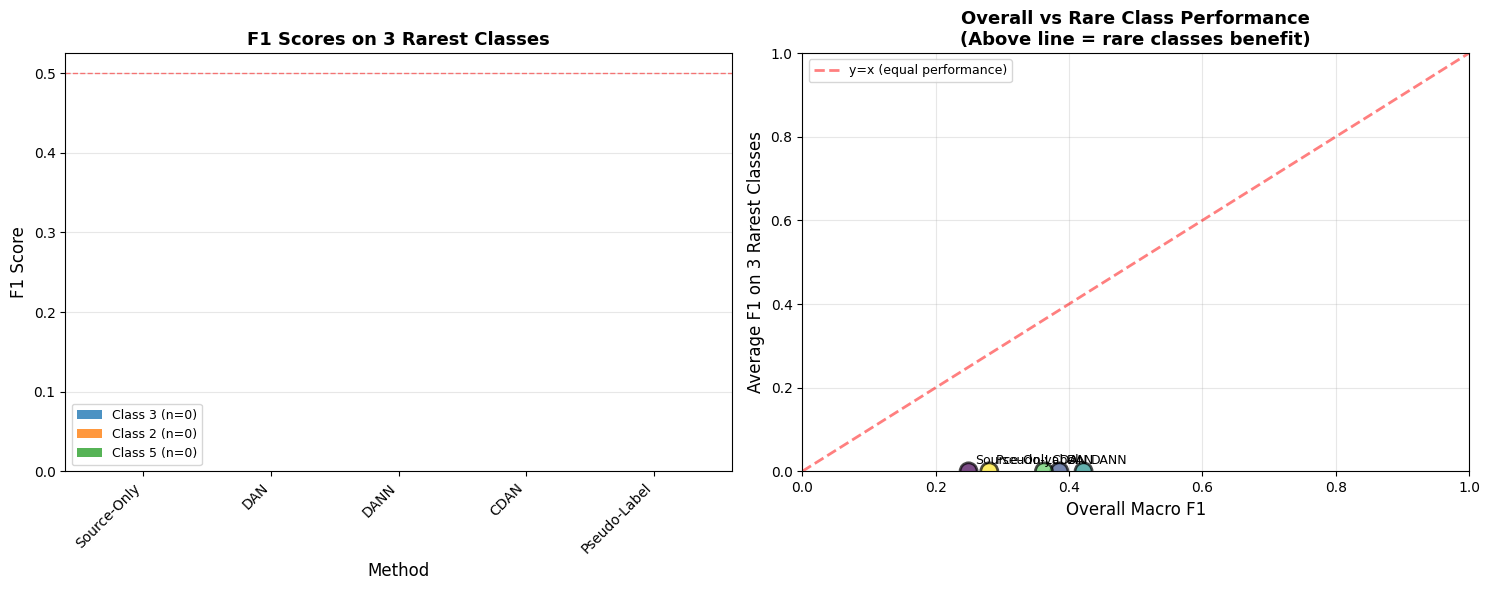


------------------------------------------------------------
RARE CLASS PERFORMANCE SUMMARY
------------------------------------------------------------
Source-Only          | Overall F1: 0.2494 | Rare Avg F1: 0.0000 | Diff: -0.2494
DAN                  | Overall F1: 0.3856 | Rare Avg F1: 0.0000 | Diff: -0.3856
DANN                 | Overall F1: 0.4219 | Rare Avg F1: 0.0000 | Diff: -0.4219
CDAN                 | Overall F1: 0.3624 | Rare Avg F1: 0.0000 | Diff: -0.3624
Pseudo-Label         | Overall F1: 0.2805 | Rare Avg F1: 0.0000 | Diff: -0.2805
------------------------------------------------------------

✓ COMPLETE VISUALIZATION SUITE FINISHED

All results saved to: label_shift_outputs/

Generated files:
  Per-model folders:
    - Source-Only/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
      ├── per_class_metrics.png
      └── metrics_summary.txt
    - DAN/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matr

In [85]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_p
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_p
    },
    source_dataset=source_train,
    target_dataset=target_label_shift,
    source_test_loader=source_test_loader,
    target_test_loader=target_label_shift_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='label_shift_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

In [86]:
import shutil

shutil.make_archive('/kaggle/working/label_shift_outputs', 'zip', 'label_shift_outputs')

'/kaggle/working/label_shift_outputs.zip'

## All Results

In [93]:
def create_summary_table():
    print("\n" + "="*100)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*100)

    headers = ['Method', 'Source Acc', 'Target Acc', 'Target Gain',
               'Domain Clf Acc', 'Shifted Rare Acc', 'Shifted label Acc']

    print(f"{headers[0]:<15} {headers[1]:<12} {headers[2]:<12} {headers[3]:<12} "
          f"{headers[4]:<15} {headers[5]:<12} {headers[6]:<10} ")
    print("-"*100)

    baseline_target = results['Source-Only']['target_acc']

    for name in models.keys():
        source_acc = results[name]['source_acc']
        target_acc = results[name]['target_acc']
        gain = target_acc - baseline_target
        dom_clf_acc = domain_distances[name]['classifier_acc']
        a_dist = domain_distances[name]['a_distance']
        rarest_classes = [5, 6, 3]
        # rare_f1 = np.mean([f1_results[name][cls] for cls in rarest_classes])

        shifted_rare_acc = shifted_results_rare[name]['accuracy']
        shifted_label_acc = shifted_results_label[name]['accuracy']

        print(f"{name:<15} {source_acc:<12.2f} {target_acc:<12.2f} {gain:<+12.2f} "
              f"{a_dist:<12.4f} {shifted_rare_acc:<12.2f} {shifted_label_acc:<12.2f}")

# {rare_f1:<10.4f}
    print("="*100)
    print("\nInterpretation:")
    print("- Target Gain: Improvement over source-only baseline")
    print("- Domain Clf Acc: Lower = better alignment (harder to distinguish domains)")
    print("- A-Distance: Proxy for domain divergence (lower = better)")
    print("- Rare F1: Average F1 on 3 rarest classes (measures negative transfer)")
    print("- Shifted Acc: Performance under label distribution shift")
    print("="*100 + "\n")
create_summary_table()



COMPREHENSIVE RESULTS SUMMARY
Method          Source Acc   Target Acc   Target Gain  Domain Clf Acc  Shifted Rare Acc Shifted label Acc 
----------------------------------------------------------------------------------------------------
Source-Only     95.47        60.43        +0.00        1.9960       56.01        50.40       
DAN             90.02        66.16        +5.73        1.9960       62.81        70.16       
DANN            92.42        74.81        +14.38       1.9720       72.79        76.09       
CDAN            88.95        70.48        +10.05       1.9920       67.15        61.26       
Pseudo-Label    90.27        62.47        +2.04        1.9960       57.31        54.74       

Interpretation:
- Target Gain: Improvement over source-only baseline
- Domain Clf Acc: Lower = better alignment (harder to distinguish domains)
- A-Distance: Proxy for domain divergence (lower = better)
- Rare F1: Average F1 on 3 rarest classes (measures negative transfer)
- Shifted Acc: P